# Quality Assessment for ERA5 Drought Indicator: Reproducibility

Production date: 2026-xx-xx

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Dataset version: 1.0.

Produced by: Enis Gerxhalija, Olivier Burggraaff (National Physical Laboratory).

## 🌍 Use case: Retrieving drought indicators from the ERA5-Drought dataset 

## ❓ Quality assessment question
* **Are the drought indicators in the ERA5-Drought dataset consistent with and reproducible from ERA5 data?**
* **Are the drought indicators in the ERA5-Drought dataset presented in a format that ensures optimal usability for users?**

Human-induced climate change is likely the primary driver behind the number of increased droughts and heavy precipitation since the 1950s, per the latest assessment report by the Intergovernmental Panel on Climate Change [IPCC, 2013](https://www.ipcc.ch/report/ar6/syr/downloads/report/IPCC_AR6_SYR_LongerReport.pdf). With further global warming at 1.5°C and above, heavy precipitation, flooding and drought events are projected to intensify and become more frequent in most regions of Africa, Asia, North America and Europe. The environmental and societal impact of such extreme weather events are far-reaching. In the United Kingdom alone, the 2020s have seen three of the five worst harvests on record, with extreme heat and drought in 2025 causing more than £800mn lost revenue in harvest, [Energy & Climate Intelligence Unit](https://mcusercontent.com/8ed7ad7972fae058e8f4fb7e8/files/6d02e6e7-8639-a44d-5a8c-2313124ef699/Costs_of_climate_analysis_011225.pdf). In 2023-2024, the Amazon region in Brazil faced an 18-month drought considered the most severe since drought monitoring began in 1954. By November 2024, it left 720 health centres in drought-affected areas of Brazil to become non-operational [UNICEF, 2024](https://www.unicef.org/media/165191/file/LACR-Flash-Update-11-November-2024.pdf).

A large scientific effort has gone into identifying areas more prone to drought along with monitoring areas currently experiencing drought conditions and accurately quantifying their severity [reference]. The objective quantification of drought severity remains an ongoing endeavour amongst scientists as there is not one physical variable that describes a drought. One might assume that drought severity can be measured by the total precipitation in that region, but this would overlook water-loss from the land surface through evapotranspiration, soil moisture levels, temperature anomalies and other natural variables. There is however consensus that drought indices, proxies based on long-term and shorter-term historical weather data, can accurately quantify drought severity and their impact, with studies linking the variability of drought indices to crop yields, [Vicente‐Serrano et al.](https://doi.org/10.1080/01431160500296032), and frequency of wildfires [reference]. Two widely-employed drought indices are the Standardised Precipitation Index (SPI) [reference](), endorsed by the World Metereological Organisation (WMO), and the more recent Standardised Precipitation-Evapotranspiration Index (SPEI) [reference](). 

The ERA5-Drought dataset provides a reanalysis-based dataset of the aforementioned indices using the ECMWF Reanalysis version 5 (ERA5), at a resolution of 0.25° globally (around 28 km) from the start of the reanalysis (in 1940) to today, [Keune et al., ‘ERA5–Drought’](https://doi.org/10.1038/s41597-025-04896-y). The ERA5-Drought dataset consists of 1 deterministic and 10 ensemble drought-index members from slightly different initial conditions, enabling an estimate of the uncertainty.

This notebook aims to give users much-needed confidence and transparency in the calculation of the two drought indices along with their quality flags. The C3S ERA5-Drought dataset must be consistent with and reproducible from its origins. Here, we assess this consistency and reproducibility by comparing drought-indicators retrieved from the ERA5-Drought dataset with their equivalents calculated from the origin dataset (or similar). While a full analysis and reproduction of every record within the C3S ERA5-Drought dataset is outside the scope of quality assessment (as it would require high-performance computing infrastructure), a case study with a narrower scope probes these quality attributes of the dataset and can be a jumping-off point for further analysis by the reader.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Conclusion 1
* Conclusion 2

## 📋 Methodology

This quality assessment tests the consistency between drought indices retrieved from the [C3S ERA5-Drought dataset] and their equivalents calculated from the origin datasets, as well as the reproducibility and usability of said dataset.

We will examine the SPI and SPEI drought indicators calculated from the following datasets:

(include table here of the parameter, description of that parameters, and the origin dataset)

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-1)**
 * \\\\\\\\\\\\\\\\\\\\\
 * Import all required libraries.
 * Define helper functions.
 * \\\\\\\\\\\\\\\\\\\\\\
**[](section-2)**
 * Define SPI Indicator
 * Download ERA5 precipitation
 * Accumulate
 * Calculate SPI
 * Calculate quality flags from ERA5 data
 * Download quality flags from ERA5-Drought
 * Compare quality flags
 * Download ERA5-Drought SPI
 * Comparison
 * \\\\\\\\\\\\\\\\\\
**[](section-3)**
 * Define SPEI Indicator
 * Download ERA5 potential evaporation
 * Accumulate
 * Calculate SPEI
 * Calculate quality flags from ERA5 data
 * Download quality flags from ERA5-Drought
 * Compare quality flags
 * Download ERA5-Drought SPEi
 * Comparison
 * \\\\\\\\\\\\\\\\\\\\\
**[](section-4)**
 
**[](section-5)** 

Any further notes on the method could go here (explanations, caveats or limitations).

## 📈 Analysis and results

(section-1)=
### 1. Code setup.

```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data. Because earthkit is in active development, some functionality may change after this notebook is published. If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [1]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd
import warnings

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial

# Analysis
import calendar
from scipy import stats

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

# Type hints
from typing import Callable, Iterable, Optional
from scipy.stats import rv_continuous as Distribution
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

#### Helper functions
This section defines some functions and variables used in the following analysis, allowing code cells in later sections to be shorter and ensuring consistency.

##### Data (pre-)processing
The following functions handle [data chunking in dask](https://docs.xarray.dev/en/latest/user-guide/dask.html) for computational efficiency:

In [2]:
def rechunk(data: xr.Dataset) -> xr.Dataset:
    """ Re-chunk a dataset into pre-determined optimal chunks. """
    # Might need to be adjusted for different coordinate names
    return data.chunk({"valid_time": -1, "latitude": 103, "longitude": 360})

##### Accumulation periods
The following cells ...

In [3]:
# Define constants such as the accumulation periods to use
ACCUMULATION_PERIODS = [1, 3, 6, 12, 24, 36, 48]  # Months
MONTHS = range(1, 13)  # January to December (inclusive)

# Perform accumulation
def accum_var(data: xr.Dataset, var: str, *,
              accumulation_periods: Iterable[int]=ACCUMULATION_PERIODS, time_dim: Optional[str]=None) -> xr.Dataset:
    """
    Compute the precipitation / potential evaporation accumulation window. 
    
    1. Convert precipitation/potential evaporation from meters to millimeters.
    2. Compute monthly totals (accounting for days in month).
    3. Add rolling accumulation windows on monthly totals.
    """
    # Detect time dimension if not provided
    # TO DO: Use the first dimension that contains "time"?
    if time_dim is None:
        if 'valid_time' in data.dims:
            time_dim = 'valid_time'
        elif 'forecast_reference_time' in data.dims:
            time_dim = 'forecast_reference_time'
        elif "time" in data.dims:
            time_dim = "time"
        else:
            raise ValueError("No valid time dimension found. Expected 'valid_time' or 'forecast_reference_time'.")

    # Ensure time is sorted
    # TO DO: Is this necessary?
    data = data.sortby(time_dim)
    
    # Step 1: Convert to mm
    data[f'{var}_mm'] = data[var] * 1000

    # Step 2: Compute monthly totals
    # TO DO: Is this necessary for the analysis (I don't think so) or only for the plot?
    # In the latter case, you could (don't need to) either make this optional or split it out altogether
    time_index = pd.to_datetime(data[time_dim].values)
    
    days_in_month = xr.DataArray(
        time_index.days_in_month,
        coords={time_dim: data[time_dim]},
        dims=[time_dim]
    )

    data[f'{var}_mm_monthly_total'] = data[f'{var}_mm'] * days_in_month
    data[f'{var}_mm_monthly_total'] = data[f'{var}_mm_monthly_total'].astype("float64")

    # Step 3: Add rolling accumulation windows
    for period in accumulation_periods:
        rolling_sum = data[f"{var}_mm_monthly_total"].rolling({time_dim: period}, center=False).sum()
        data[f'{var}_mm_accum_{period}m'] = rolling_sum

    data = data.chunk({time_dim: -1})

    return data.drop_vars([f"{var}", f"{var}_mm", f"{var}_mm_monthly_total"])

##### Calculating SPI / SPEI

The following functions ... fitting:

In [4]:
def fit_monthly_distributions_xr(reference_data: xr.Dataset, var: str, *,
                                 accumulation_periods: Iterable[int]=ACCUMULATION_PERIODS, time_dim: Optional[str]=None) -> xr.Dataset:
    """
    Fit gamma/genlogistic distributions for each month and accumulation period using xarray.
    Data are assumed to have been sliced to the reference period.
    """
    monthly_params = {}

    # Detect time dimension if not provided
    # TO DO: Use the first dimension that contains "time"?
    # TO DO: Refactor so can be re-used
    if time_dim is None:
        if 'valid_time' in reference_data.dims:
            time_dim = 'valid_time'
        elif 'forecast_reference_time' in reference_data.dims:
            time_dim = 'forecast_reference_time'
        else:
            raise ValueError("No valid time dimension found. Expected 'valid_time' or 'forecast_reference_time'.")

    for period in accumulation_periods:
        var_name = f'{var}_mm_accum_{period}m'
        for month in range(1, 13):
            # Select month subset
            month_subset = reference_data[var_name].where(reference_data[time_dim].dt.month == month, drop=True)

            # Drop NaNs and flatten
            values = month_subset.values.flatten()
            values = values[~np.isnan(values)]
            if len(values) > 0:
                # TO DO: Make the fitting distribution an argument to the function,
                # then use functools.partial to create defaults
                # e.g. function call: (..., var: str, distribution: Callable, ...)
                # and the part below becomes alpha, loc, beta = distribution.fit(values)
                # and then define
                # fit_monthly_spi  = partial(fit_monthly_distributions_xr, distribution=stats.gamma)
                # fit_monthly_spei = partial(fit_monthly_distributions_xr, distribution=stats.genlogistic)
                if var == "tp":
                    alpha, loc, beta = stats.gamma.fit(values)
                elif var == "pev" or "wb":
                    alpha, loc, beta = stats.genlogistic.fit(values) # alpha is shape parameters, loc = location, beta is scale.

            # Else?
            monthly_params[(month, period)] = (alpha, loc, beta) # TODO: put into a xarray.
    return monthly_params

In [5]:
# General fitting function
def fit_monthly_distributions_new(reference_data: xr.Dataset, distribution: Distribution, *,
                                  time_dim: Optional[str]=None) -> xr.Dataset:
    """
    Fit distributions (e.g. gamma) for each month and accumulation period using xarray parallelisation.
    Data are assumed to have been sliced to the reference period.
    """
    # Define fitting function
    def fit(y):
        y = y[np.isfinite(y)]
        params = distribution.fit(y) #500 ,loc=-1000, scale = 5)
        params = np.stack(params, axis=-1)  # Extend with axis for stats (alpha, loc, scale ...)
        return params

    # Split dataset by month
    if time_dim is None:  # Detect time dimension if not provided
        time_dim = next(dim for dim in reference_data.dims if "time" in dim)  # TO DO: Refactor so can be re-used
    reference_data_by_month = reference_data.groupby(reference_data[time_dim].dt.month)

    # Apply fitting function by month
    params = xr.apply_ufunc(fit, reference_data_by_month,
                            input_core_dims=[[time_dim]], output_core_dims=[["stat"]],
                            vectorize=True,
                            dask="parallelized",
                            dask_gufunc_kwargs={"output_sizes": {"stat": distribution.numargs+2}},  # e.g. 3 for gamma (alpha, loc, scale)
                            output_dtypes=[np.float64],
                           )
    params = params.chunk({"month": -1})

    return params

# Fitting functions for SPI, SPEI specifically
fit_monthly_spi  = partial(fit_monthly_distributions_new, distribution=stats.gamma) # partial function
fit_monthly_spei = partial(fit_monthly_distributions_new, distribution=stats.genlogistic)

##### The following functions ... applying fitted distributions to calculate SPI / SPEI:

In [7]:
# General computing function
def compute_monthly_series_new(data: xr.Dataset, monthly_params: xr.Dataset, distribution: Distribution, *,
                               index_name: Optional[str]=None, time_dim: Optional[str]=None) -> tuple[xr.Dataset]:
    """
    Compute SPI time series for each accumulation period using fitted distribution parameters.
    Returns two datasets: CDF values and index (SPI/SPEI) values.
    """
    # Create a month dimension for broadcasting with the one in monthly_params
    if time_dim is None:  # Detect time dimension if not provided
        time_dim = next(dim for dim in data.dims if "time" in dim)  # TO DO: Refactor so can be re-used
    month_da = data[time_dim].dt.month.rename("month")

    # Extract parameters
    nr_params = params_fitted.sizes["stat"]  # 3 for gamma and genlogistic
    params_extracted = [params_fitted.sel(stat=j).sel(month=month_da) for j in range(nr_params)]

    # Calculate CDF values by month
    cdf = xr.apply_ufunc(distribution.cdf, data, *params_extracted,
                         input_core_dims=[[], [], [], []], output_core_dims=[[]],
                         vectorize=True, dask="parallelized",
                         output_dtypes=[np.float64],
                         keep_attrs=True
                        )
    cdf = cdf.chunk({time_dim: -1})
    
    clipped = cdf.clip(1e-16, 1 - 1e-16)

    # Convert CDF to index
    index = xr.apply_ufunc(stats.norm.ppf, clipped,
                           input_core_dims=[[]], output_core_dims=[[]],
                           vectorize=True, dask="parallelized",
                           output_dtypes=[np.float64],
                           keep_attrs=True
                          )

    # Optional: Rename variables in index dataset to e.g. SPI12
    if index_name:
        accumulation_variables = {var: var.split("_")[-1][:-1] for var in index.variables if "accum" in var}  # Get periods as number strings
        rename_variables = {var: f"{index_name}{accumulation_period}" for var, accumulation_period in accumulation_variables.items()}
        index = index.rename_vars(rename_variables)

    return cdf, index

# Computing functions for SPI, SPEI specifically
compute_monthly_spi  = partial(compute_monthly_series_new, distribution=stats.gamma, index_name="SPI")
compute_monthly_spei = partial(compute_monthly_series_new, distribution=stats.genlogistic, index_name="SPEI")

def compute_spi_dataset(data, accum_periods, n_points = 1000):
    """
    Fit gamma distribution for each month and accumulation period,
    then compute SPI, CDF, and PDF for a linspace of precipitation values.
    """
    result_vars = {}

    for period in accum_periods:
        var_name = f'tp_mm_accum_{period}m'
        
        tp_values = data[var_name]

        # Prepare storage lists
        spi_list, cdf_list, pdf_list, precip_list = [], [], [], []

        for month in range(1, 13):
            # Select month subset
            month_data = tp_values.where(tp_values['valid_time.month'] == month, drop=True).values
            month_data = month_data[month_data > 0]                
            month_data = month_data[~np.isnan(month_data)]

                
            # Fit gamma distribution
            alpha, loc, beta = stats.gamma.fit(month_data, floc=0)

            vals = np.linspace(month_data.min(), month_data.max(), n_points)

            # Compute PDF, CDF, SPI
            cdf_vals = stats.gamma.cdf(vals, a=alpha, loc=loc, scale=beta)
            spi_vals = stats.norm.ppf(cdf_vals)
            pdf_vals = stats.gamma.pdf(vals, a=alpha, loc=loc, scale=beta)

            # Append to lists
            precip_list.append(vals)
            spi_list.append(spi_vals)
            cdf_list.append(cdf_vals)
            pdf_list.append(pdf_vals)

            
        # Convert lists to DataArrays
        months = np.arange(1, 13)
        
        result_vars[f'precip_{period}m'] = xr.DataArray(precip_list, dims=['month', 'value_index'], coords={'month': months})
        result_vars[f'SPI_{period}m'] = xr.DataArray(spi_list, dims=['month', 'value_index'], coords={'month': months})
        result_vars[f'CDF_{period}m'] = xr.DataArray(cdf_list, dims=['month', 'value_index'], coords={'month': months})
        result_vars[f'PDF_{period}m'] = xr.DataArray(pdf_list, dims=['month', 'value_index'], coords={'month': months})

    return xr.Dataset(result_vars)
    
def zero_precip_monthly_xr(prec_data: xr.Dataset, cdf_ds: xr.Dataset, reference_window, accum_periods: Iterable[int]=ACCUMULATION_PERIODS):
    """
    Adjust CDF for zero precipitation probability in xarray.
    """
    # Slice reference period, find time variable, and months.
    reference_data = prec_data.sel(**reference_window)

    reference_data = reference_data.to_array("accumulation_period")
    
    time_dim = next(dim for dim in reference_data.dims if "time" in dim)  # TO DO: Refactor so can be re-used
    month = reference_data[time_dim].dt.month

    # Threshold precipitation
    prec_eps = 0.01

    # All months with precipitation less than precipitation.
    is_zero = (reference_data <= prec_eps)

    # Zero precipitation stats. 
    n_zero  = is_zero.groupby(month).sum(dim=time_dim)    
                                         
    # Count total months per calendar month
    n_month = reference_data.groupby(month).count(dim=time_dim)

    # Ratio of months with zero precipitation
    ratio_zero = n_zero / n_month

    # Weighted probability with zero precipitation.
    p_zero = xr.where(
        n_zero > 0,
        (n_zero + 1) / (2 * (n_month + 1)),
        0
    ) 

    cdf = cdf_ds.to_array("accumulation_period")
    
    cdf_data_by_month = cdf.groupby("valid_time.month") 

    adjusted_cdf = cdf_data_by_month.map(
        lambda x: p_zero.sel(month=x["valid_time.month"]) + (1 - p_zero.sel(month=x["valid_time.month"])) * x
    ) #  pass formula onto each month and then just pass back to adjusted_cdf
    
    # Convert back to Dataset
    adjusted_cdf = adjusted_cdf.to_dataset("accumulation_period")

    # Summary of stats
    stats_summary = xr.Dataset({
        "Zero-Precip Count": n_zero,
        "Total Months": n_month,
        "Prob Zero Precip": p_zero,
        "Historical Ratio": ratio_zero,
    })

    stats_summary = stats_summary.assign_coords(accumulation_period=("accumulation_period", accum_periods))
    
    return adjusted_cdf, stats_summary 
    
def xr_shapiro_test(spi_ds: xr.Dataset,accum_periods: Iterable[int]=ACCUMULATION_PERIODS, months = range(1,13) )  :
    # TODO: Optimise this function with dask and adapt to above.
    spi_ref = spi_ds.sel(valid_time=slice("1991-01-01", "2020-12-31"))
    
    spi_ref = spi_ref.where(np.isfinite(spi_ref)) # Mask non-finite values before masking.
    
    spi_ref_by_month = spi_ref.groupby("valid_time.month")
    
    # Perform shapiro on xarray
    stat, pval = xr.apply_ufunc(stats.shapiro, spi_ref_by_month, 
                           input_core_dims=[['valid_time']], output_core_dims=[[],[]],
                           vectorize=True, dask="parallelized",
                           output_dtypes=[np.float64, np.float64],
                           keep_attrs=True
                          )
    
    normality = xr.where(pval < 0.05, 0, 1) #  Values < 0.05 → 0
    
    return stat, pval, normality

def cdf_to_spi_transform(adjusted_cdf_ds):

    clipped = adjusted_cdf_ds.clip(1e-16, 1 - 1e-16)
    
    # Convert CDF to index
    adjusted_spi_ds = xr.apply_ufunc(stats.norm.ppf, clipped, 0.0, 1.0,  
                           input_core_dims=[[], [], []], output_core_dims=[[]],
                           vectorize=True, dask="parallelized",
                           output_dtypes=[np.float64],
                           keep_attrs=True
    )
    
    accumulation_variables = {var: var.split("_")[-1][:-1] for var in adjusted_spi_ds.variables if "accum" in var}  # Get periods as number strings
    rename_variables = {var: f"{"SPI"}{accumulation_period}" for var, accumulation_period in accumulation_variables.items()}
    
    return adjusted_spi_ds.rename_vars(rename_variables)

##### Helper functions for reading data.

In [8]:
def era5_drought_api_multiple(indicator, var, accum_period = [1, 3, 6, 12, 24, 36, 48]):
    ind = indicator.strip().upper()
    if ind not in {"SPI", "SPEI"}:
        raise ValueError("indicator must be 'SPI' or 'SPEI'")
    ind = ind.lower()

    var_key = var.strip().lower()
    if var_key not in {"prob_zero", "quality"}:
        raise ValueError("var must be 'prob_zero' or 'quality'")
    if var_key == "prob_zero":
        dataset_name = "derived-drought-historical-monthly"
        request_var = f"probability_of_zero_precipitation_{ind}"
        source_var_name = "pzero"
        rename_prefix = "prob_zero"
    else:
        dataset_name = "derived-drought-historical-monthly"
        request_var = f"test_for_normality_{ind}"
        source_var_name = "significance"
        rename_prefix = "significance"
    

    out = []
    
    for p in accum_period:
        request = {
            "variable": [request_var],
            "accumulation_period": [str(p)],
            "version": "1_0",
            "product_type": ["reanalysis"],
            "dataset_type": "consolidated_dataset",
            "month": [f"{m:02d}" for m in range(1, 13)],
        }

        ds = ekd.from_source("cds", dataset_name, request).to_xarray(compat="equals")
        
        if source_var_name not in ds.variables:
            raise KeyError(
                f"Expected variable '{source_var_name}' not found for period {p}. "
                f"Available: {list(ds.variables)}"
            )

        new_name = f"{rename_prefix}_{p}"
        ds_renamed = ds.rename({source_var_name: new_name})[[new_name]]
        out.append(ds_renamed)
            
    return xr.merge(out, compat="override")

(section-2)=
### 2. Calculate SPI at one location from ERA5 reanalysis data

#### Download monthly precipitation data 
First, we download the monthly-mean total precipitation data from the ERA5 reanalysis.
Generally,
one would use the [_ERA5 monthly averaged data on single levels from 1940 to present_ (reanalysis-era5-single-levels-monthly-means)](https://doi.org/10.24381/cds.f17050d7) dataset for this,
which provides pre-calculated monthly means at 0.25° by 0.25° resolution.
For this assessment,
to be as close to the ERA5-Drought data processing pipeline as possible
and
to make use of some of MARS's functionalities (see [below](section-4)),
we instead use the [_Complete ERA5 global atmospheric reanalysis_ (reanalysis-era5-complete)](https://doi.org/10.24381/cds.143582cf) dataset.

In this assessment,
we will calculate SPI and SPEI for each month
(with different accumulation periods, see below)
for the years 1940–2024.
For the reference period,
we will use the World Meteorological Organization (WMO) current standard 30-year reference period of 1991–2020,
which is also used in ERA5-Drought.
Both of these date ranges can be adjusted in the cell below when running the analysis yourself:

In [9]:
# Define your preferred analysis and reference periods
years           = (1940, 2024)  # Years for the analysis (inclusive)
years_reference = (1991, 2020)  # Years for the reference period (inclusive)

# Derived variables for convenience:
reference_window = {"valid_time": slice(f"{years_reference[0]}-01-01", f"{years_reference[1]}-12-01"),}  #  Slice (1991-01-01, 2020-12-01)
entire_window = {"valid_time": slice(f"{years[0]}-01-01", f"{years[1]}-12-01"),}  #  Slice (1940-01-01, 2024-12-01)

Having defined our target years, we can now define our CDS request.
First, we define a template with some default parameters
(e.g. years, data format)
that will also be used later in the notebook.
Additional information for specific downloads
(e.g. variable, data stream)
is mixed into this template where relevant.

This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.
If you prefer not to use earthkit, the following requests can also be used with the [cdsapi module](https://cds.climate.copernicus.eu/how-to-api#linux-use-client-step).
In either case (earthkit-data or cdsapi), it is required to set up a CDS account and API key as explained [on the CDS website](https://cds.climate.copernicus.eu/how-to-api).

In [10]:
ID_ERA5 = "reanalysis-era5-complete"

request_era5_template = {
    "class": "ea",            # Default for ERA5
    # Dates: ERA5 takes these in the format 19400101/19400201/.../20241101/20241201
    # The following line generates a string in said format from the chosen year range
    "date": "/".join(f"{year}{month:02}01"
            for year in range(years[0] ,years[1]+1)
            for month in MONTHS),
    "expver": "1",            # ERA5 consolidated data
    "levtype": "sfc",         # Surface
    "grid": "0.25/0.25",      # Grid: 0.25° by 0.25°
    "type": "fc",             # Forecast
    "data_format": "netcdf",  # NetCDF data
}

In this section, we want to download 
total precipitation data (variable `228.128`)
from the
`moda` stream (monthly-mean reanalysis data),
so we mix this information into the template
and submit the request to the CDS.
More information about formatting these requests is available in the [MARS ERA5 catalogue](https://apps.ecmwf.int/data-catalogues/era5/?class=ea).

In [11]:
request_era5_precipitation_moda = {
    "param": "228.128",       # Variable: Total precipitation
    "stream": "moda",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [12]:
# Download data and convert to desired format
era5_monthly_mean_reanal = ekd.from_source("cds", ID_ERA5, request_era5_precipitation_moda)  # Download as field list
era5_monthly_mean_reanal = era5_monthly_mean_reanal.to_xarray(compat="equals")  # Convert to xarray dataset
era5_monthly_mean_reanal = rechunk(era5_monthly_mean_reanal)  # Re-chunk for speed gain in fitting
era5_monthly_mean_reanal  # Display in notebook

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 1020, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B ...
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    tp          (valid_time, latitude, longitude) float32 4GB dask.array<chunksize=(1020, 103, 360), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts


#### 1. Calculate moving average for different accumulation periods.
A time series of precipitation for one grid point is extracted and precipitation is accumulated over the previous $n$ months using a moving window. Since the origin precipitation data from ERA5 is from the monthly mean dataset, we calculate the total precipitation for that month by multiplying with the total number of days in that month, correcting for leap years.

The different accumulation windows are used to determine the timescale of the drought. The longer the drought, typically the more severe the impact it will have.

* **1-, 3-month window**: useful for soil moisture, flow in small creaks.
* **6-, 12-month window**: looking at reservoir storage, reduced stream flow.
* **24-, 36-, 48-month window**: groundwater recharge, reduced reservoir. 


TO DO: Some text about the user choosing their point here, which point did we choose and why

In [13]:
# Define your preferred site for the SPI example
example_site = {"latitude": 9.25, "longitude": 40.5,}

In [14]:
# Select the grid point and time slice for Ethiopia
precipitation_example_site = era5_monthly_mean_reanal.sel(**example_site)

# Perform the accumulation for each accumulation period
precipitation_example_site = accum_var(precipitation_example_site, "tp")

# Display result
precipitation_example_site

<xarray.Dataset> Size: 82kB
Dimensions:          (valid_time: 1020)
Coordinates:
  * valid_time       (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... ...
    number           int64 8B ...
    latitude         float64 8B 9.25
    longitude        float64 8B 40.5
    expver           (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    tp_mm_accum_1m   (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_3m   (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_6m   (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_12m  (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_24m  (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_36m  (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    tp_mm_accum_48m  (valid_time) float64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

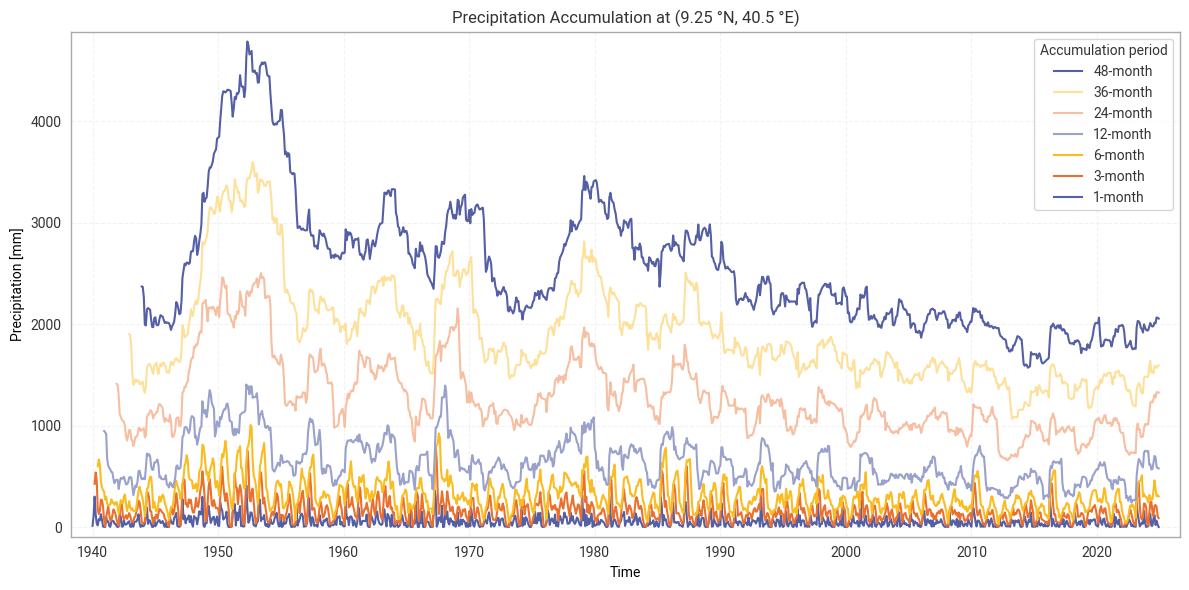

In [15]:
# TO DO: Refactor so the same function can be re-used for TP–PEV later
plt.figure(figsize=(12, 6))
for p in ACCUMULATION_PERIODS:
    var_name = f'tp_mm_accum_{p}m'
    plt.plot(precipitation_example_site['valid_time'].values, precipitation_example_site[var_name].values, label=f'{p}-month')

# Customize plot
plt.title(f"Precipitation Accumulation at ({example_site['latitude']} °N, {example_site['longitude']} °E)")
plt.xlabel("Time")
plt.ylabel("Precipitation [mm]")
plt.legend(title="Accumulation period", reverse=True) # plot legend in reverse to match order of the lines (top-to-bottom).
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

#### 2. Fit gamma distribution (over calendar months) to different accumulation periods.

The gamma distribution [reference] is fitted only to the data within the reference period (1991-2020). A separate distribution is fitted for each calendar month per accumulation window. 

For e.g. : in the 3-month accumulation window, a gamma distribution is fitted on all 30 Januaries in that reference period, all the Februaries (30 of them) and so forth... 

This fitting is done with the [scipy.stats.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) object in Python. Three parameters are then outputted per calendar month, per accumulation period: the shape ($\alpha$), location ($\beta$) and scale ($\lambda$) parameter.

In [16]:
# Temporarily moved into separate cell for testing -- merge back into fitting cell below when done
precipitation_example_site_reference = precipitation_example_site.sel(**reference_window) # select only reference precipitation window.
precipitation_example_site_entire = precipitation_example_site.sel(**entire_window) # select only reference precipitation window.

In [17]:
# OB function testing (new)
params_fitted = fit_monthly_spi(precipitation_example_site_reference)
params_fitted 

<xarray.Dataset> Size: 2kB
Dimensions:          (month: 12, stat: 3)
Coordinates:
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    number           int64 8B ...
    latitude         float64 8B 9.25
    longitude        float64 8B 40.5
Dimensions without coordinates: stat
Data variables:
    tp_mm_accum_1m   (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_3m   (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_6m   (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_12m  (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_24m  (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_36m  (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
    tp_mm_accum_48m  (month, stat) float64 288B dask.array<chunksize=(12, 3), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

#### 3. Compute SPI series

From the parameters from the gamma distribution fitting, we calculate the cumulative distribution function or CDF, $F(x, \alpha, \beta, \lambda)$, up to the accumulated precipitation $x$, from the probability distribution function or PDF, $f(u, \alpha, \beta, \lambda)$:

\begin{equation}
F(x, \alpha, \beta, \lambda) = \int_{0}^{x}f(u, \alpha, \beta, \lambda) \, du.
\end{equation}

A one-to-one mapping of SPI-index to accumulated precipitation value is then obtained by transforming the cumulative probability values to a standard normal distribution with a mean ($\mu$) of zero and standard deviation ($\sigma$) of 1. This mapping is applied to the historical record of the accumulated precipitation values in that calendar month and accumulation window.

\begin{equation}
\text{SPI-index} = \Phi^{-1}\big(F(x, \alpha, \beta, \lambda)\big)
\end{equation}


In [18]:
# Compute SPI series -- new function
cdf_ds, spi_ds = compute_monthly_spi(precipitation_example_site_entire, params_fitted)

##### Plot of Precipitation vs CDF (for different accumulation windows).

In [ ]:
plt.figure(figsize=(12, 6))

from scipy.interpolate import CubicSpline

spi_month_ds = spi_ds_prec.where(spi_ds_prec.month == 5, drop=True)

for p in accum_periods:
    var1_name = f'SPI_{p}m'
    var2_name = f'CDF_{p}m'
    var3_name = f'precip_{p}m'
    cs = CubicSpline(spi_month_ds[var2_name].values.ravel(), spi_month_ds[var3_name].values.ravel())
    x_range = np.arange(-0.01, 1.01, 0.01)
    plt.plot(cs(x_range), x_range, label=f'{p}-month')
    # plt.scatter(spi_ds[var1_name].values, cdf_ds[var2_name].values, label=f'{p}-month')
    # plt.scatter(spi_month_ds[var1_name].values, spi_month_ds[var3_name].values, label=f'{p}-month', s=10)

# Customize plot
plt.title('CDF vs Precipitaiton')
plt.xlabel('Precipitation (mm)')
plt.ylabel('CDF')
plt.ylim([0,1])
plt.legend(title='Accumulation Period')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Plot of Precipitation vs SPI (for different accumulation windows).

In [ ]:
plt.figure(figsize=(12, 6))

from scipy.interpolate import CubicSpline

spi_month_ds = spi_ds_prec.where(spi_ds_prec.month == 5, drop=True)

for p in accum_periods:
    var1_name = f'SPI_{p}m'
    var2_name = f'CDF_{p}m'
    var3_name = f'precip_{p}m'
    cs = CubicSpline(spi_month_ds[var1_name].values.ravel(), spi_month_ds[var3_name].values.ravel())
    x_range = np.arange(-3, 3, 0.01)
    plt.plot(x_range, cs(x_range), label=f'{p}-month')
    # plt.scatter(spi_ds[var1_name].values, cdf_ds[var2_name].values, label=f'{p}-month')
    # plt.scatter(spi_month_ds[var1_name].values, spi_month_ds[var3_name].values, label=f'{p}-month', s=10)

# Customize plot
plt.title('Precipitation vs SPI')
plt.xlabel('SPI')
plt.ylabel('Precipitation (mm)')
plt.legend(title='Accumulation Period')
# plt.xlim([-1, 1])
plt.grid(True)
plt.tight_layout()
plt.show()

##### Plot of SPI vs CDF (for different accumulation windows).

In [ ]:
plt.figure(figsize=(12, 6))

from scipy.interpolate import CubicSpline

spi_month_ds = spi_ds_prec.where(spi_ds_prec.month == 5, drop=True)

for p in accum_periods:
    var1_name = f'SPI_{p}m'
    var2_name = f'CDF_{p}m'
    var3_name = f'precip_{p}m'
    cs = CubicSpline(spi_month_ds[var1_name].values.ravel(), spi_month_ds[var2_name].values.ravel())
    x_range = np.arange(-3, 3, 0.01)
    plt.plot(x_range, cs(x_range), label=f'{p}-month')
    # plt.scatter(spi_ds[var1_name].values, cdf_ds[var2_name].values, label=f'{p}-month')
    # plt.scatter(spi_month_ds[var1_name].values, spi_month_ds[var3_name].values, label=f'{p}-month', s=10)

# Customize plot
plt.title('Precipitation vs SPI')
plt.xlabel('SPI')
plt.ylabel('Precipitation (mm)')
plt.legend(title='Accumulation Period')
# plt.xlim([-1, 1])
plt.grid(True)
plt.tight_layout()
plt.show()

#### 4. Calculating historical ratio of months without precipitation and finding zero adjusted SPI (ref dataset)
In regions of extremely low precipitation (e.g. the Sahara desert), months may have little to no accumulated precipitation. This poses a problem when fitting the gamma distribution since it is defined only for positive, real values. Furthermore, a criteria is set so that out of the 30 months in the reference period, per calendar month & accumulation window, 10 months must have non-zero accumulated precipitations. Otherwise, the calendar month is reported as having no value.

Months with zero precipitation are defined as less than 0.1 mm by the [Copernicus European (EDO) and Global (GDO) Drought Observatories](https://drought.emergency.copernicus.eu/). The ERA5-Drought dataset appears to define months with zero precipitation as having an accumulated precipitation exactly equal to zero. 

To get around some months having zero precipitation, the CDF is adjusted with the historical occurrence $p_{0}$ of periods with zero precipitation [Stagge et al., ‘Candidate Distributions for Climatological Drought Indices](https://doi.org/10.1002/joc.4267).

\begin{equation}
F_{p_{0}}(x_{p>0},  \alpha, \beta, \lambda) = p_{0} + \big(1 - p_{0}\big) \, F(x_{p>0},  \alpha, \beta, \lambda),
\end{equation}

where $F_{p_{0}}(x_{p>0},  \alpha, \beta, \lambda)$ is the CDF adjusted for zero precipitation.

This simple treatment can lead to a z-distribution that is skewed, with a non-zero mean. Therefore, special care must be taken, and $p_{0}$ must be adjusted for the "centre of probability mass" following:

\begin{equation}
\bar{p}_{0} = \frac{n_{p=0} + 1}{2(n + 1)},
\end{equation}

where $n_{p=0}$ are the number of calendar months in the reference period per accumulation window, and n are the total number of calendar months (30 reference calendar months).

\begin{equation}
F_{\bar{p}_{0}}(x, \alpha, \beta, \lambda) =
\begin{cases}
\bar{p}_{0} + (1 - \bar{p}_{0}) \, F(x_{p>0},  \alpha, \beta, \lambda), & x > 0, \\[6pt]
\frac{n_{p=0} + 1}{2(n+1)}, & x = 0.
\end{cases}
\end{equation}
This maintains the mean SPI value of zero, allowing for an objective statistical comparison.

In [19]:
adjusted_cdf_ds, stats_sum = zero_precip_monthly_xr(precipitation_example_site_entire, cdf_ds, reference_window)

#### 5. Adjust SPI values with zero precipitation probability.

The CDF adjusted for months of zero precipitation is once again transformed to the z-normal distribution:

\begin{equation}
\text{Adjusted SPI-index} = \Phi^{-1}\big(F_{\bar{p}_{0}}(x,  \alpha, \beta, \lambda)\big)
\end{equation}

In [20]:
def cdf_to_spi_transform(adjusted_cdf_ds):

    clipped = adjusted_cdf_ds.clip(1e-16, 1 - 1e-16)
    
    # Convert CDF to index
    adjusted_spi_ds = xr.apply_ufunc(stats.norm.ppf, clipped, 0.0, 1.0,  
                           input_core_dims=[[], [], []], output_core_dims=[[]],
                           vectorize=True, dask="parallelized",
                           output_dtypes=[np.float64],
                           keep_attrs=True
    )
    
    accumulation_variables = {var: var.split("_")[-1][:-1] for var in adjusted_spi_ds.variables if "accum" in var}  # Get periods as number strings
    rename_variables = {var: f"{"SPI"}{accumulation_period}" for var, accumulation_period in accumulation_variables.items()}
    
    return adjusted_spi_ds.rename_vars(rename_variables)

adjusted_spi_ds = cdf_to_spi_transform(adjusted_cdf_ds)

#### Importing ERA5-Drought SPI data from dataset for comparison.
Data request must be "weaved" as request too big for entire time range.

In [ ]:
drought_dataset = "derived-drought-historical-monthly"

spi_request1 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "1940", "1941", "1942",
        "1943", "1944", "1945",
        "1946", "1947", "1948",
        "1949", "1950", "1951",
        "1952", "1953", "1954",
        "1955", "1956", "1957",
        "1958", "1959", "1960",
        "1961", "1962", "1963",
        "1964", "1965", "1966",
        "1967", "1968", "1969",
        "1970", "1971", "1972",
        "1973", "1974", "1975",
        "1976", "1977", "1978",
        "1979", "1980"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "area": [9.45, 40.25, 8.95, 40.75]
}

spi_request2 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "1981", "1982", "1983",
        "1984", "1985", "1986",
        "1987", "1988", "1989",
        "1990", "1991", "1992",
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "area": [9.45, 40.25, 8.95, 40.75] # Ethiopia
}

era5_drought_spi = ekd.from_source("cds", drought_dataset, spi_request1, spi_request2) # Sends request for this dataset to CDS.
era5_drought_spi = era5_drought_spi.to_xarray(compat="equals") # Converts to xarray.
era5_drought_spi = era5_drought_spi.sel(lat=9.25,lon=40.5, method="nearest")

#### Comparison of the calculated SPI-index vs ERA5-Drought SPI-index (qualatitive)
Now that we have calculated the SPI-index for one grid point, for all accumulation windows, we make a qualatitive and quantitative comparison with the corresponding data in the ERA5-Drought dataset. 

First, we plot the timeseries of the SPI drought index, calculated and from the derived dataset.

In [ ]:
# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 12), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle('ERA5-Drought SPI vs Calculated SPI for varying windows.', fontsize=16)

# Flatten axs for easy indexing
axs = axs.flatten()

for position, period in enumerate(ACCUMULATION_PERIODS):
    ax = axs[position]

    # Plot ERA5 drought SPI
    ax.plot(era5_drought_spi[f"SPI{period}"].time,
            era5_drought_spi[f"SPI{period}"],
            label=f"ERA5_Drought-SPI{period}",
            color="tab:blue")

    # Plot calculated SPI
    ax.plot(adjusted_spi_ds[f"SPI{period}"].valid_time,
            adjusted_spi_ds[f"SPI{period}"],
            label=f"Calculated SPI{period}",
            color="tab:orange")

    # Title for each subplot
    ax.sharex(axs[0])
    ax.set_title(f"{period}-Month Window", fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('SPI')    
    ax.grid(True)

# Remove unused axes
for i in range(len(ACCUMULATION_PERIODS), len(axs)):
    fig.delaxes(axs[i])

# Add a single legend for the whole figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2, frameon=True)
plt.show()

#### Comparison of the calculated SPI-index vs ERA5-Drought SPI-index (quantative- plot of residuals & frequency histogram).


In [ ]:
residual  = adjusted_spi_ds_focus[f"SPI1"] - era5_drought_spi[f"SPI1"]


In [ ]:
adjusted_spi_ds_focus = adjusted_spi_ds.rename({
    "valid_time": "time",
    "latitude": "lat",
    "longitude": "lon",
}) # for alignment

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 12), sharex=True, sharey=False, constrained_layout=True)
fig.suptitle('Residual SPI for varying windows.', fontsize=16)

# Flatten axs for easy indexing
axs = axs.flatten()

for position, period in enumerate(ACCUMULATION_PERIODS):
    ax = axs[position]
    # Plot residual between ERA5-SPI & Calculated-SPI
    ax.plot(residual.time,
            residual,
            label=f"Residual-SPI{period}",
            color="tab:blue")

    # Title for each subplot
    ax.sharex(axs[0])
    ax.set_title(f"{period}-Month Window", fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Residual SPI')    
    ax.grid(True)
    # ax.set_ylim([-1e-5, 1e-5])

# Remove unused axes
for i in range(len(ACCUMULATION_PERIODS), len(axs)):
    fig.delaxes(axs[i])

# Add a single legend for the whole figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2, frameon=True)
plt.show()

In [ ]:
adjusted_spi_ds_focus = adjusted_spi_ds.rename({
    "valid_time": "time",
    "latitude": "lat",
    "longitude": "lon",
}) # for alignment

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 12), sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Residual SPI for varying windows.', fontsize=16)

# Flatten axs for easy indexing
axs = axs.flatten()

for position, period in enumerate(accum_periods):
    ax = axs[position]
    
    residual  = adjusted_spi_ds_focus[f"SPI_{period}m"] - era5_drought_spi[f"SPI{period}"]
    
    vals = (residual.values).ravel() 
    
    finite_mask = np.isfinite(vals)
    
    vals = vals[finite_mask]

    count = vals.size
    mean_val = np.nanmean(vals)
    std_val = np.nanstd(vals)

    freq, bin_edges = np.histogram(vals, bins=20)
    rel_freq = freq / count
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot relative frequency histogram
    ax.bar(bin_centers, rel_freq, width=(bin_edges[1] - bin_edges[0]))
    
    ax.annotate(
            f"Mean residual - SPI {period}: {mean_val: .7f}\n Std residual- SPI {period}: {std_val: .7f}",
            xy=(0.02, 0.95), xycoords="axes fraction",  # position in axes coords
            fontsize=10,
            ha="left", va="top",
        )
    
    # Title for each subplot
    ax.sharex(axs[0])
    ax.set_title(f"{period}-Month Window", fontsize=10)
    ax.set_xlabel('Residual SPI')
    ax.set_ylabel('Frequency')    
    ax.grid(True)
    
# Remove unused axes
for i in range(len(accum_periods), len(axs)):
    fig.delaxes(axs[i])

# Add a single legend for the whole figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2, frameon=True)
plt.show()

####  6. Comparison of Probability of Zero Precipitation to that from ERA5-Drought dataset.
You can also import the "probability of zero precipitation" for a given calendar month, in the reference period, per accumulation period instead of calculating it as we have done. 

Due to improper formatting from ERA5-Drought, you are unable to send an API request to download the data for all accumulation periods at once. If you try to do so, you will find that your xarray only contains the data for the last accumulation period (in this case, the 48-month window). 

We have written a simple helper function, "era5_api_multiple" that sends separate API requests, concatenating the data into a single xarray, to then use.

In [ ]:
prob_spi_zero_all = era5_drought_api_multiple(indicator = "spi", var = "prob_zero")

In [ ]:
prob_spi_zero_all_ds = prob_spi_zero_all.sel(lat=9.25,lon=40.5, method="nearest")

In [ ]:
prob_spi_zero_all_ds = prob_spi_zero_all_ds.to_array("accumulation_period")

In [ ]:
prob_spi_zero_all_ds = prob_spi_zero_all_ds.assign_coords(accumulation_period=("accumulation_period", ACCUMULATION_PERIODS))

In [ ]:
stats_sum

In [ ]:
prob_spi_zero_all_ds

In [ ]:
prob_zero_diff = prob_spi_zero_all_ds.groupby('time.month') - stats_sum["Zero-Precip Count"]

In [ ]:
cond =  (prob_zero_diff != 0).compute()

In [ ]:
mis_match = prob_zero_diff.where(cond, drop=True)

In [ ]:
mis_match

#### 7. Quality control using the Shapiro-Wilks test on calculated SPI data.
Quality control is performed by the ERA5-Drought team over the entire dataset. This is done by testing if the calculated distribution of the estimated drought indices over the reference period follows a normal distribution with mean 0 and standard deviation 1. 

This test is performed using the Shapiro-Wilks test for normality [S. S. SHAPIRO, M. B. WILK, An analysis of variance test for normality (complete samples), Biometrika, Volume 52, Issue 3-4, December 1965, Pages 591–611](https://doi.org/10.1093/biomet/52.3-4.591), with a $\alpha$ = 0.05 on the data in the reference period (1991-2020). 

If the resultant p-value is less than $\alpha$ = 0.05, the corresponding quality parameter is set to 0 (bad), otherwise set to 1 (good).

We perform this test over the calculated SPI values, that are adjusted for zero-precipitation. 

In [ ]:
stat, pval, sig = xr_shapiro_test(spi_ref)

##### Importing Shapiro-Wilks SPI Significance Test results from ERA5-Drought dataset.
You can also import the quality flags from ERA5-Drought, for every calendar month, in the reference period, per accumulation period. 

Due to improper formatting from ERA5-Drought, you are unable to send an API request to download this data for all accumulation periods at once. If you try to do so, you will find that your xarray only contains the data for the last accumulation period (in this case, the 48-month window). 

We have written a simple script that sends separate API requests, concatenating the data into a single xarray, to then use.

In [ ]:
quality_spi_all = era5_drought_api_multiple(indicator = "spi", var = "quality")

In [ ]:
quality_spi_all = quality_spi_all.sel(lat=9.25, lon = 40.5)

##### Comparison of significance values

In [ ]:
sig

In [ ]:
sig_diff = quality_spi_all.groupby('time.month') - sig
cond =  (sig_diff != 0).compute()
# Does cond have any True anywhere?
any_true = cond.any().compute()   # -> bool

if not any_true:
    print("Values from ERA5 Significance match calculated significance values.")

#### Calculating ERA5-Drought SPI (across a region)
Repeat calculations here but very quickly (i.e. just follow the steps from before but without all the steps and plots in between)
All functions should be written so that they can take data with only one (lat, lon) point as before or the entire dataset at once

##### Accumulation precipitations

In [ ]:
acc_periods = [48]

# Select latitude and longitude box (keeping small for smaller compute time, recommended 10 x 10)
lon_min, lon_max = 19.0, 21.5   
lat_min, lat_max = 41.0, 43.5

# Subset (latitude is descending in ERA5)
ds_loc = era5_monthly_mean_reanal.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
)

ds_loc = accum_var(ds_loc, var = "tp")

precipitation_example_site_reference = ds_loc.sel(**reference_window) # select only reference precipitation window.

##### Fit gamma distribution onto site.

In [ ]:
params_fitted = fit_monthly_spi(precipitation_example_site_reference)

##### Calculate SPI over region.

In [ ]:
precipitation_example_site_entire = ds_loc.sel(**entire_window) # select only reference precipitation window.

In [ ]:
cdf_ds, spi_ds = compute_monthly_spi(precipitation_example_site_entire, params_fitted)

##### Adjust for zero precipitation

In [ ]:
adjusted_cdf_ds, stats_sum = zero_precip_monthly_xr(precipitation_example_site_entire, cdf_ds, reference_window) # takes a while

In [ ]:
adjusted_spi_ds = cdf_to_spi_transform(adjusted_cdf_ds)

In [ ]:
dataset = "derived-drought-historical-monthly"

request1 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "1940", "1941", "1942",
        "1943", "1944", "1945",
        "1946", "1947", "1948",
        "1949", "1950", "1951",
        "1952", "1953", "1954",
        "1955", "1956", "1957",
        "1958", "1959", "1960",
        "1961", "1962", "1963",
        "1964", "1965", "1966",
        "1967", "1968", "1969",
        "1970", "1971", "1972",
        "1973", "1974", "1975",
        "1976", "1977", "1978",
        "1979", "1980"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ], 
    "area": [43.5, 19.0, 41.0, 21.5]  # lat, lon 
}

request2 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "1981", "1982", "1983",
        "1984", "1985", "1986",
        "1987", "1988", "1989",
        "1990", "1991", "1992",
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "area": [43.5, 19.0, 41.0, 21.5] # lat, lon 
}

era5_spi = ekd.from_source("cds", dataset, request1,request2) # Sends request for this dataset to CDS.
era5_spi = era5_spi.to_xarray(compat="equals") # Converts to xarray.

In [ ]:
era5_spi

In [ ]:
adjusted_spi_ds

In [ ]:
# adjusted_spi_ds = adjusted_spi_ds.rename({
#     "valid_time": "time",
#     "latitude": "lat",
#     "longitude": "lon"})

In [ ]:
spi_drought, adjusted_spi_ds = xr.align(spi_drought, adjusted_spi_ds, join="left")   # only overlapping coords
# spi_diff_mean = spi_diff.mean(dim="time")

In [ ]:
spi_diff_mean = abs(adjusted_spi_ds["SPI48"]-spi_drought["SPI48"]).mean("time")

In [ ]:
spi_diff = abs(adjusted_spi_ds["SPI48"]-spi_drought["SPI48"])

In [ ]:
# Select one time slice and one ensemble
from earthkit.plots.styles import Style
from earthkit.plots.geo import domains

global_mean_map = spi_diff

balkans = domains.Domain.from_bbox(
    bbox=[15, 25, 36, 47],
    name="Balkans",
)
# Convert to NumPy arrays

mean_values = global_mean_map.to_numpy()
lat_values = global_mean_map.lat.to_numpy()
lon_values = global_mean_map.lon.to_numpy()
 
# Create meshgrid

lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
 
# # Plot with EarthKit

SPI_STYLE = Style(cmap='viridis', vmin = -0.1, vmax = 0.1, normalize=False)

# Create figure with 2 columns
fig = ekp.Figure(rows=1, columns=1, size=(12, 6))  

# First subplot (left)
subplot = fig.add_map(domain=balkans, row=0, column=0)
subplot.grid_cells(mean_values, x=lon_grid, y=lat_grid,style=SPI_STYLE)
subplot.legend(location="right")

# Add decorations
fig.title("ERA5 - Calculated SPI")
fig.land()
fig.coastlines()
fig.borders()
fig.gridlines()
fig.show()

(section-3)=
###  Calculating ERA5-Drought SPEI from reanalysis origin data.
The steps to calculating the SPEI-index are exactly the same as calculating the SPI index, with the only modification being that the SPEI integrates both the precipitation and potential evapotranspiration (PET) data. 

#### 0. Importing monthly-average potential evaporation data.

We import the monthly-mean potential evaporation data from the "ERA5 monthly-averaged data on single levels from 1940 to present" dataset.(https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

In [21]:
request_era5_pev_moda = {
    "param": "251.228",       # Variable: Potential evaporation (pev)
    "stream": "moda",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [22]:
# Download data and convert to desired format
era5_monthly_mean_pev_reanal = ekd.from_source("cds", ID_ERA5, request_era5_pev_moda)  # Download as field list
era5_monthly_mean_pev_reanal = era5_monthly_mean_pev_reanal.to_xarray(compat="equals")  # Convert to xarray dataset
era5_monthly_mean_pev_reanal = rechunk(era5_monthly_mean_pev_reanal)  # Re-chunk for speed gain in fitting
era5_monthly_mean_pev_reanal  # Display in notebook

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 1020, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B ...
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    pev         (valid_time, latitude, longitude) float32 4GB dask.array<chunksize=(1020, 103, 360), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

#### 1. Calculate moving average for different accumulation periods (PET/PEV & TP).

A time series of both precipitation & potential evaporation (PET/PEV) from one grid point are extracted and the precipitation & potential evaporation are accumulated over the previous $n$ months using a moving window, analogous to the SPI.

Note, [ECMWF convention](https://codes.ecmwf.int/grib/param-db/182) is that negative values for PEV/PET indicate evaporation, whereas positive values indicate condensation.

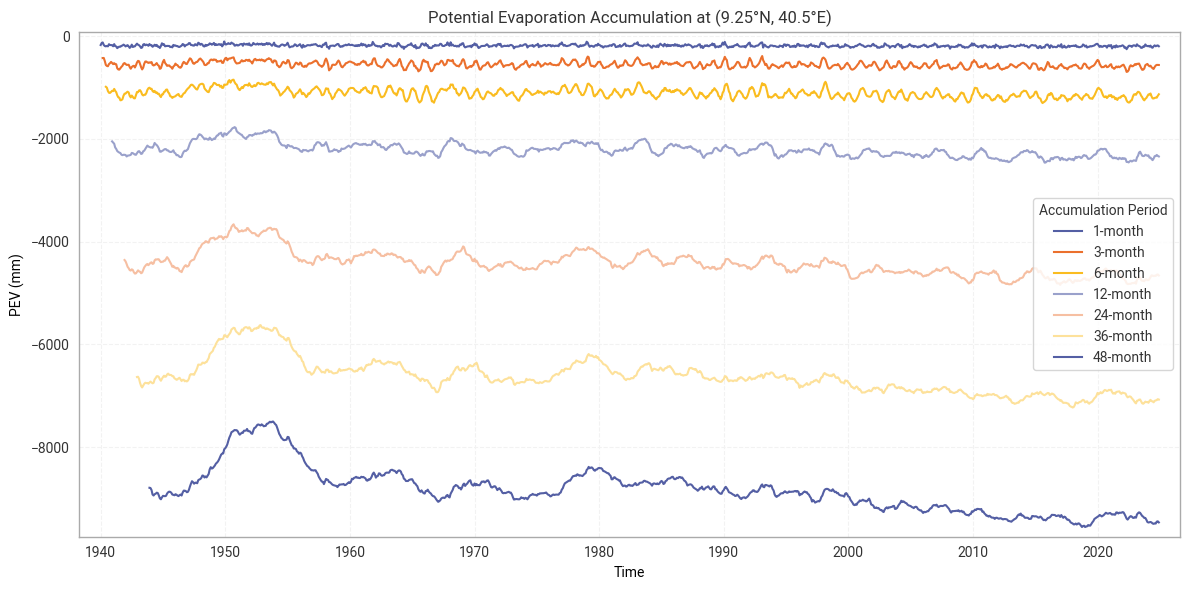

In [33]:
# Select the grid point and time slice for Ethiopia
pev_example_site = era5_monthly_mean_pev_reanal.sel(**example_site)

# Perform the accumulation for each accumulation period
pev_example_site = accum_var(pev_example_site, "pev")

# Display result
pev_example_site

plt.figure(figsize=(12, 6))
for p in ACCUMULATION_PERIODS:
    var_name = f'pev_mm_accum_{p}m'
    plt.plot(pev_example_site['valid_time'].values, pev_example_site[var_name].values, label=f'{p}-month')

# Customize plot
plt.title('Potential Evaporation Accumulation at (9.25°N, 40.5°E)')
plt.xlabel('Time')
plt.ylabel('PEV (mm)')
plt.legend(title='Accumulation Period')
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
wb_ds = xr.Dataset(
    {
        f"wb_{var.replace('tp_', '')}": precipitation_example_site[var]
                                       + pev_example_site[var.replace("tp_", "pev_")]
        for var in precipitation_example_site.data_vars # loop through every variable.
        if var.startswith("tp_") and var.replace("tp_", "pev_") in pev_example_site.data_vars
    }
)

#### Plot of the accumulated water balance (P-PET).
Since the ECMWF convention is that a negative value of PET indicates evaporation, care must be taken when subtracting the precipitation by the potential evaporation (PEV/PET).

The negative of PEV/PET must be applied, meaning that $P − (−PET) = P + PET$ in this case. 

This approach aligns with the definition of the water balance, where a negative water balance value indicates that more water is potentially being transferred to the atmosphere. It also makes sense when interpreting the accumulated plots of both potential evaporation and water balance in a country like Ethiopia (below), where one might expect more evaporation and in fact has a negative water balance (as is the case).



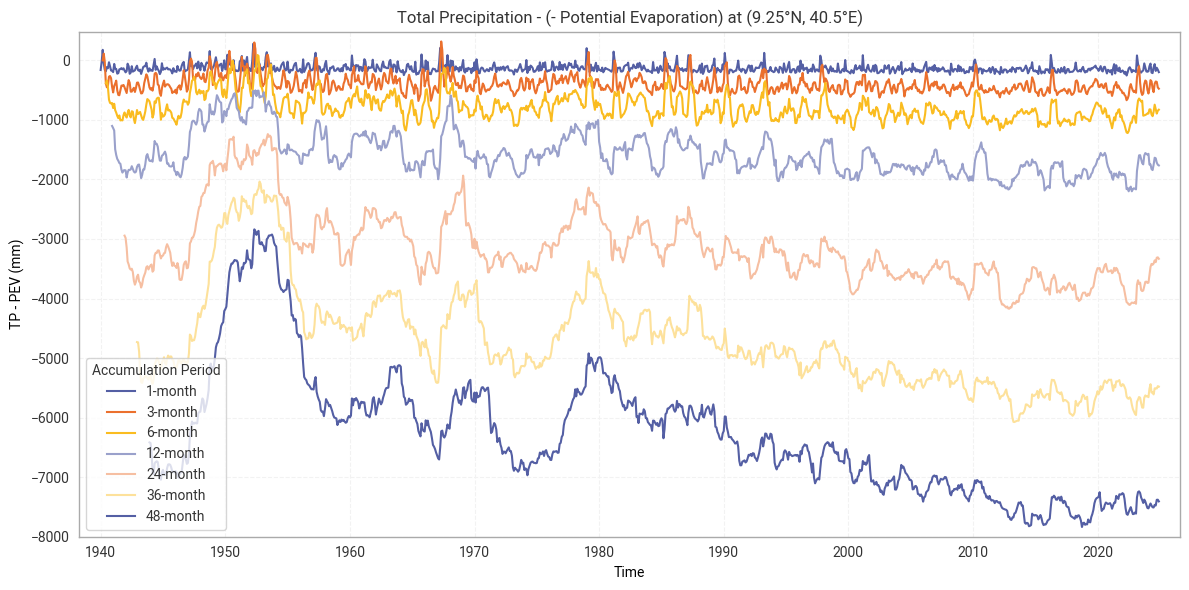

In [35]:
plt.figure(figsize=(12, 6))
for p in ACCUMULATION_PERIODS:
    var_name = f'wb_mm_accum_{p}m'
    plt.plot(wb_ds['valid_time'].values, wb_ds[var_name].values, label=f'{p}-month')

# Customize plot
plt.title('Total Precipitation - (- Potential Evaporation) at (9.25°N, 40.5°E)')
plt.xlabel('Time')
plt.ylabel('TP - PEV (mm)')
plt.legend(title='Accumulation Period')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2. Fit Generalised Log-Logistic Distribution to PET.

The general log-logistic distribution [reference] is fitted only to the data within the reference period (1991-2020), similar to the gamma distribution being fitted in the calculation of the SPI-index. A separate distribution is fitted for each calendar month per accumulation window.

This fitting is done with the [scipy.stats.genlogistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genlogistic.html) object in Python. Three parameters are then outputted per calendar month, per accumulation period: the shape (), location () and scale () parameter.

In [36]:
# Fit log logistic distributions
log_params_fitted = fit_monthly_spei(wb_ds.sel(**reference_window))

#### 3. Compute SPEI series.

Similar to the calculation for the SPI index, the three parameters from the fitted general log-logistic distribution are taken and the cumulative distribution function (CDF) is calculated up to the accumulated water balance, from the probability distribution function (PDF).

As $ P − PET $ is barely identical to 0, no modifications analogous to the SPI such as adjusting for zero precipitation, are required.

In [ ]:
params_fitted = log_params_fitted.rename({v: v.replace("tp_", "wb_")
                                          for v in log_params_fitted.data_vars})

In [40]:
# Compute SPI series
cdf_spei_ds, spei_ds = compute_monthly_spei(wb_ds, params_fitted)

#### 4. Quality control using the Shapiro-Wilks test on calculated SPEI data.

Shapiro-Wilks test is performed on the calculated SPEI index below.

In [41]:
stat, pval, sig = xr_shapiro_test(spei_ds.sel(**reference_window))

##### Importing Shapiro-Wilks SPI Significance Test results from ERA5-Drought dataset.
Quality flags ar imported from ERA5-Drought, for every calendar month, in the reference period, per accumulation period for the SPEI index.

Due to improper formatting from ERA5-Drought, you are unable to send an API request to download this data for all accumulation periods at once. If you try to do so, you will find that your xarray only contains the data for the last accumulation period (in this case, the 48-month window). 

We have written a simple script that sends separate API requests, concatenating the data into a single xarray, to then use.

In [46]:
quality_spei_all = era5_drought_api_multiple(indicator = "spei", var = "quality")

##### Comparing Calculated Shapiro-Wilks SPI Significance Test with that from ERA5-Drought dataset.

In [47]:
# select quality flags at one location and compare that with dataset.
quality_spei_all_ds = quality_spei_all.sel(lat=9.25,lon=40.5, method="nearest")

sig_diff = quality_spei_all_ds.groupby('time.month') - sig
cond =  (sig_diff != 0).compute()
# Does cond have any True anywhere?
any_true = cond.any().compute()   # -> bool

if not any_true:
    print("Values from ERA5 Significance match calculated significance values.")

Values from ERA5 Significance match calculated significance values.


#### Comparison of the calculated SPEI-index vs ERA5-Drought SPEI-index (qualatitive)

In [42]:
dataset = "derived-drought-historical-monthly"
request1 = {
    "variable": ["standardised_precipitation_evapotranspiration_index"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "1940", "1941", "1942",
        "1943", "1944", "1945",
        "1946", "1947", "1948",
        "1949", "1950", "1951",
        "1952", "1953", "1954",
        "1955", "1956", "1957",
        "1958", "1959", "1960",
        "1961", "1962", "1963",
        "1964", "1965", "1966",
        "1967", "1968", "1969",
        "1970", "1971", "1972",
        "1973", "1974", "1975",
        "1976", "1977", "1978",
        "1979", "1980", "1981"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "area": [9.45, 40.25, 8.95, 40.75]
}

request2 = {
    "variable": ["standardised_precipitation_evapotranspiration_index"],
    "accumulation_period": [
        "1",
        "3",
        "6",
        "12",
        "24",
        "36",
        "48"
    ],
    "version": "1_0",
    "product_type": ["reanalysis"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "area": [9.45, 40.25, 8.95, 40.75]
}

data_spei = ekd.from_source("cds", dataset, request1,request2) # Sends request for this dataset to CDS.
data_spei = data_spei.to_xarray(compat="equals") # Converts to xarray.
data_spei = data_spei.sel(lat=9.25,lon=40.5, method="nearest")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 190.30it/s]
/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  return xr.open_mfdataset(


NameError: name 'accum_periods' is not defined

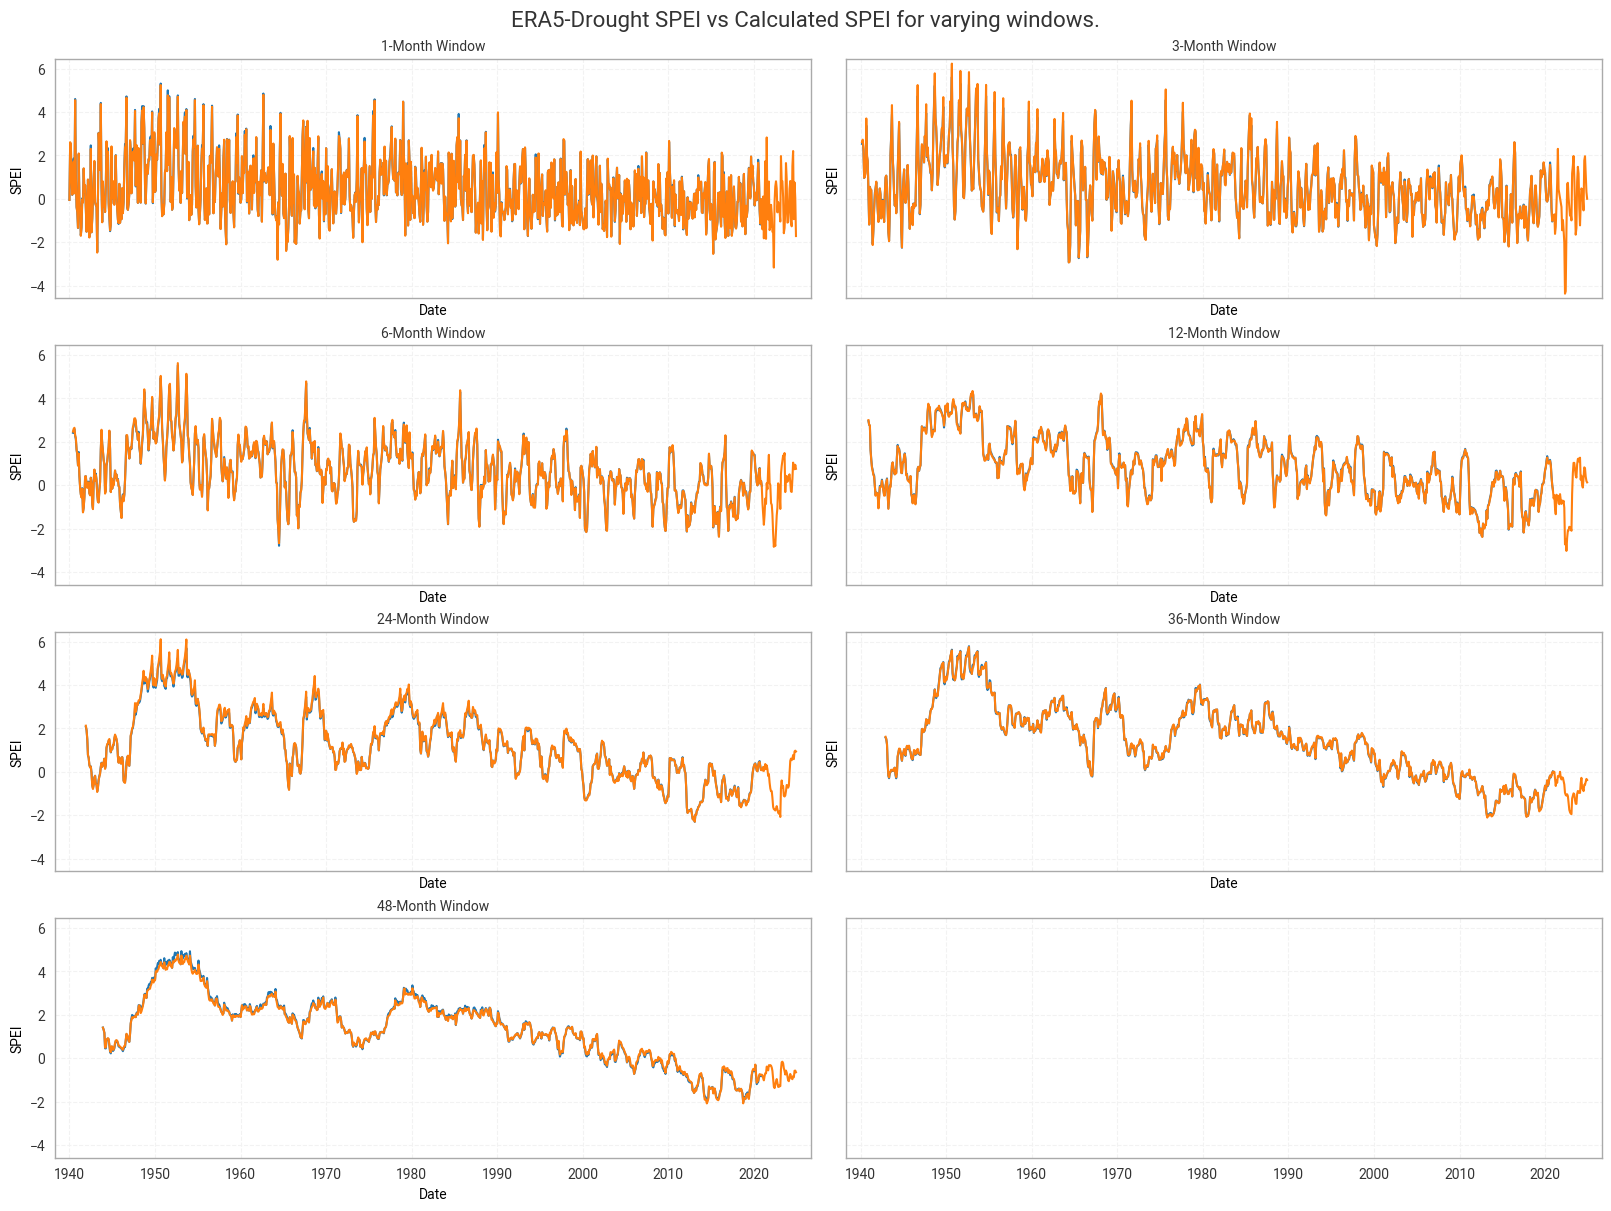

In [43]:
# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 12), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle('ERA5-Drought SPEI vs Calculated SPEI for varying windows.', fontsize=16)

data_spei_focus, spei_ds_focus = xr.align(data_spei, spei_ds, join = "override")   # only overlapping coords

# Flatten axs for easy indexing
axs = axs.flatten()

for position, period in enumerate(ACCUMULATION_PERIODS):
    ax = axs[position]

    # Plot ERA5 drought SPI
    ax.plot(data_spei_focus[f"SPEI{period}"].time,
            data_spei_focus[f"SPEI{period}"],
            label=f"ERA5_Drought-SPEI{period}",
            color="tab:blue")

    # Plot calculated SPI
    ax.plot(spei_ds[f"SPEI{period}"].valid_time,
            spei_ds[f"SPEI{period}"],
            label=f"Calculated SPEI{period}",
            color="tab:orange")

    # Title for each subplot
    ax.sharex(axs[0])
    ax.set_title(f"{period}-Month Window", fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('SPEI')    
    ax.grid(True)

# Remove unused axes
for i in range(len(accum_periods), len(axs)):
    fig.delaxes(axs[i])

# Add a single legend for the whole figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2, frameon=True)
plt.show()

#### Comparison of the calculated SPEI-index vs ERA5-Drought SPEI-index (quantatitive)

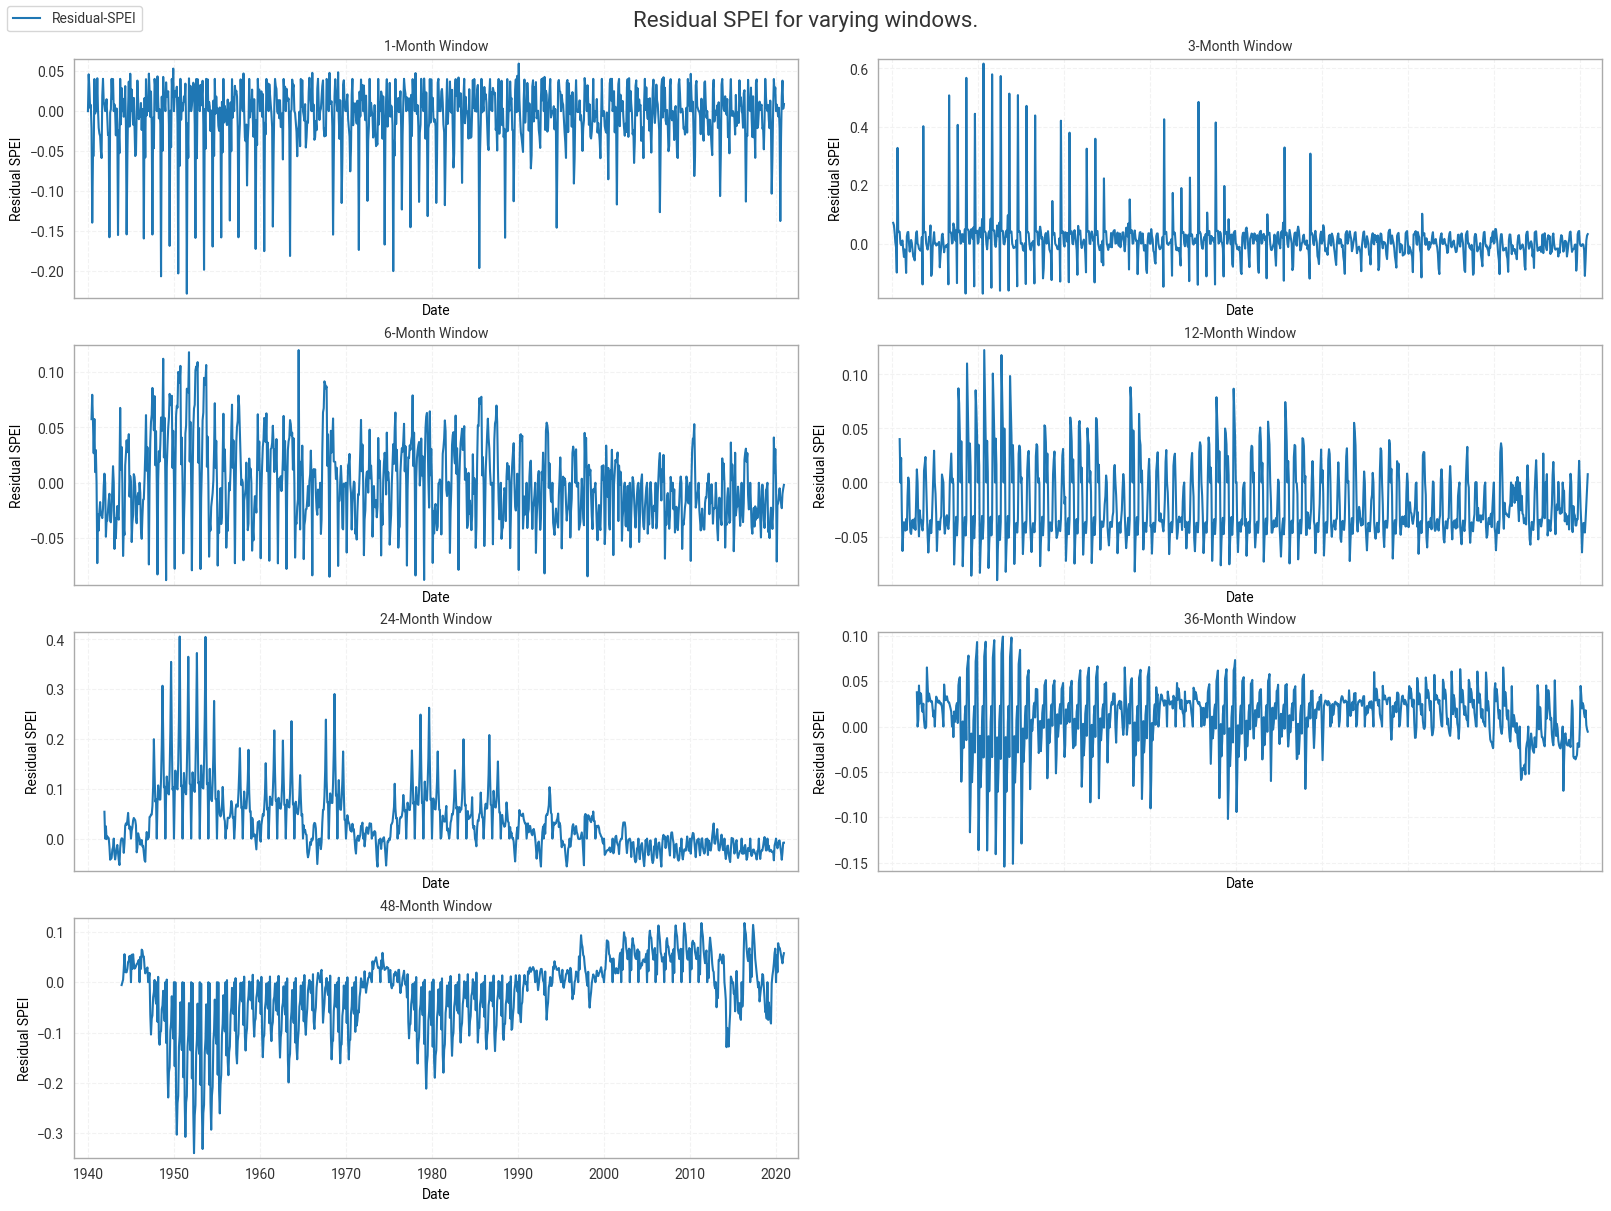

In [50]:
accum_periods = [1, 3, 6, 12, 24, 36, 48]

spei_ds_focus = spei_ds.rename({
    "valid_time": "time",
    "latitude": "lat",
    "longitude": "lon",
}) # for alignment

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 12), sharex=True, sharey=False, constrained_layout=True)
fig.suptitle('Residual SPEI for varying windows.', fontsize=16)

# Flatten axs for easy indexing
axs = axs.flatten()

for position, period in enumerate(accum_periods):
    ax = axs[position]
    residual  = spei_ds_focus[f"SPEI{period}"] - data_spei_focus[f"SPEI{period}"]
    # Plot residual between ERA5-SPI & Calculated-SPI
    ax.plot(residual.time,
            residual,
            label=f"Residual-SPEI",
            color="tab:blue")

    # Title for each subplot
    ax.sharex(axs[0])
    ax.set_title(f"{period}-Month Window", fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Residual SPEI')    
    ax.grid(True)
    # ax.set_ylim([-1e-5, 1e-5])

# Remove unused axes
for i in range(len(accum_periods), len(axs)):
    fig.delaxes(axs[i])

# Add a single legend for the whole figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2, frameon=True)
plt.show()

#### Comparison of the calculated SPEI-index vs ERA5-Drought SPEI-index with quality flags (quantatitive)

In [51]:
accum_periods = [1, 3, 6, 12, 24, 36, 48]

for period in accum_periods:
    drought_spi = data_spei_focus[f"SPEI{period}"].copy()
    calc_spi = spei_ds_focus[f"SPEI{period}"].copy() # copy so it doesn't change.
    
    for month in range(1,13):        
        significance = quality_spei_all_ds[f"significance_{period}"].sel(time=f"2020-{month:02d}-01").compute().item()
        if significance == 0:
            drought_spi = drought_spi.where(drought_spi.time.dt.month != month, other=np.nan) # keeps EVERY other month- the selected one becomes nan. 
            calc_spi = calc_spi.where(calc_spi.time.dt.month != month, other=np.nan)
        else:
            pass 
    
    data_spei_focus[f"SPEI{period}"] = drought_spi # bring it back.
    adjusted_spi_ds[f"SPEI{period}"] = calc_spi
    

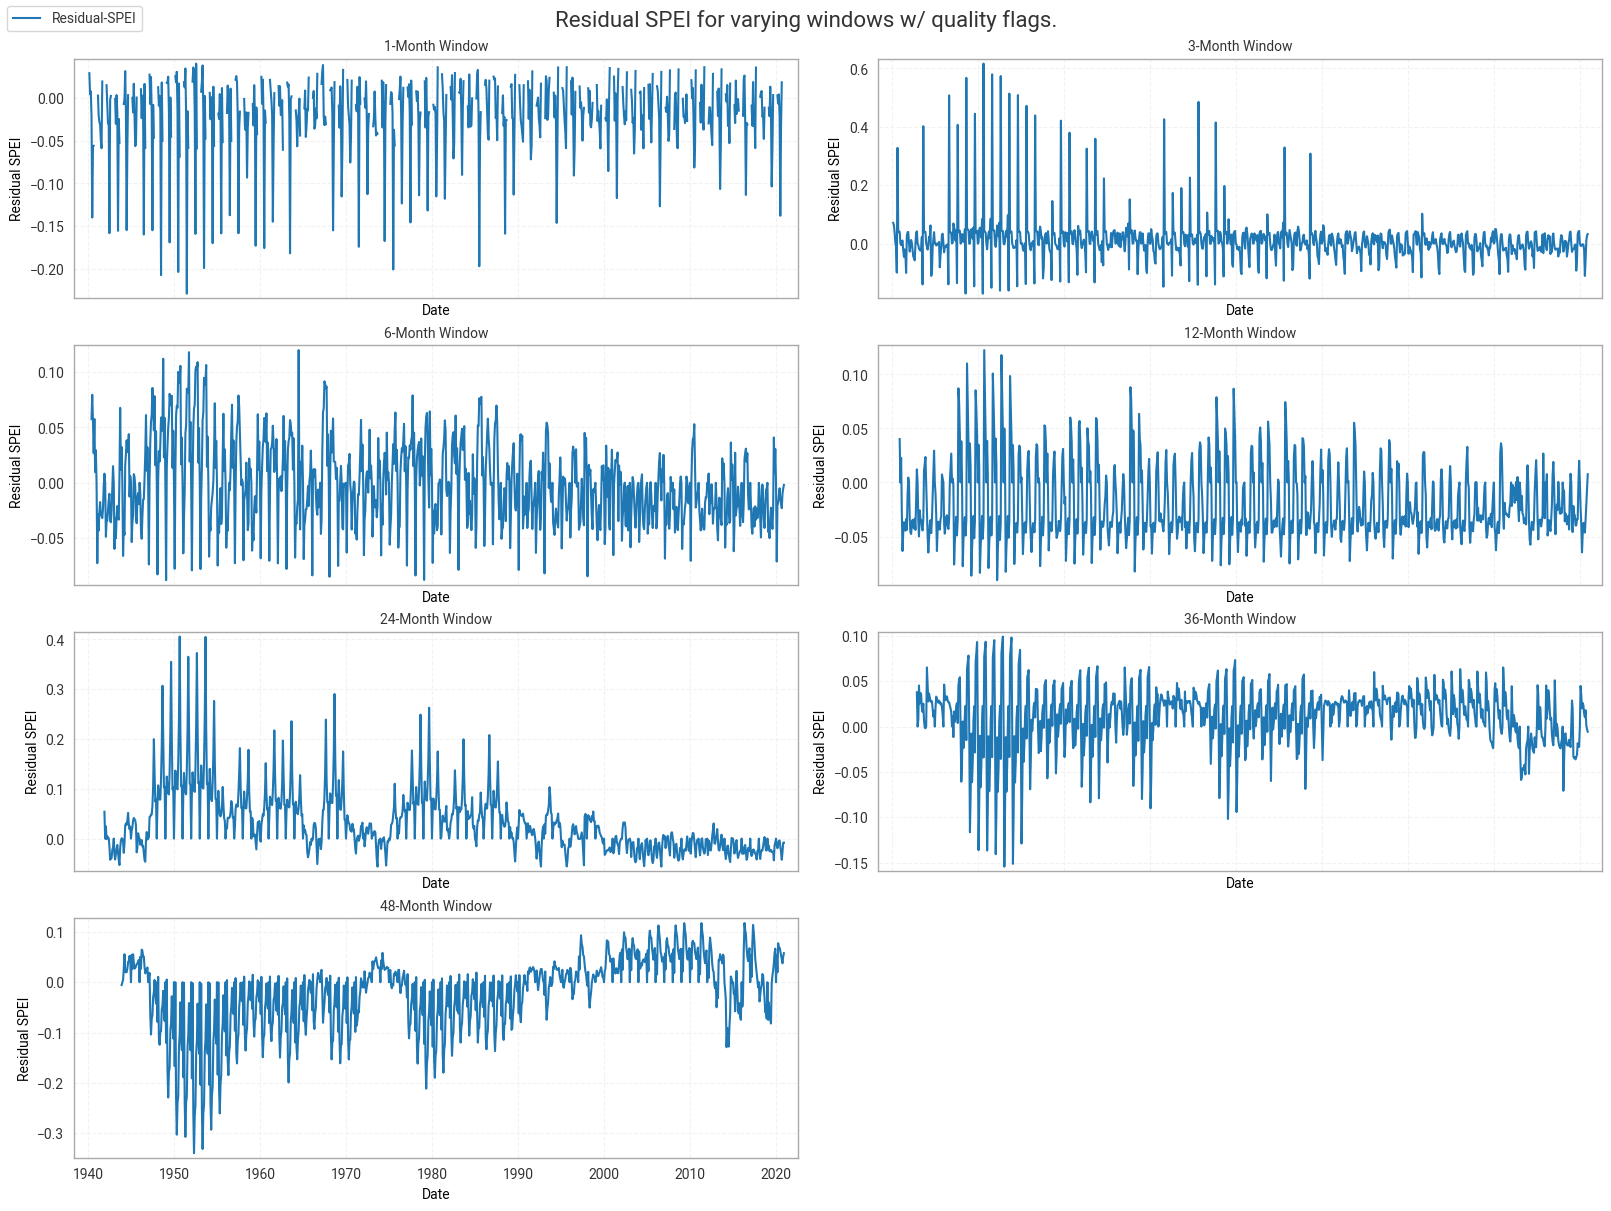

In [53]:
accum_periods = [1, 3, 6, 12, 24, 36, 48]

# data_spei_focus, spei_ds_focus = xr.align(data_spei_focus, spei_ds_focus, join = "override")   # only overlapping coords

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 12), sharex=True, sharey=False, constrained_layout=True)
fig.suptitle('Residual SPEI for varying windows w/ quality flags.', fontsize=16)

# Flatten axs for easy indexing
axs = axs.flatten()

for position, period in enumerate(accum_periods):
    ax = axs[position]
    residual  = adjusted_spi_ds[f"SPEI{period}"] - data_spei_focus[f"SPEI{period}"]
    # Plot residual between ERA5-SPI & Calculated-SPI
    ax.plot(residual.time,
            residual,
            label=f"Residual-SPEI",
            color="tab:blue")

    # Title for each subplot
    ax.sharex(axs[0])
    ax.set_title(f"{period}-Month Window", fontsize=10)
    ax.set_xlabel('Date')
    ax.set_ylabel('Residual SPEI')    
    ax.grid(True)
    # ax.set_ylim([-1e-5, 1e-5])

# Remove unused axes
for i in range(len(accum_periods), len(axs)):
    fig.delaxes(axs[i])

# Add a single legend for the whole figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2, frameon=True)
plt.show()

(section-4)=
### 4. Playing with ERA5 SPI - Ensemble 

#### Subsections
Describe what is done in this step/section and what the `code` in the cell does(if code is included).

#### Importing SPI-12 Index from ERA5 ensemble. 

In [ ]:
spi_ens_dataset = "derived-drought-historical-monthly"
spi_ens_request = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": ["12"], # 1 is also already downloaded.
    "version": "1_0",
    "product_type": ["ensemble_members"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "1940", "1941", "1942",
        "1943", "1944", "1945",
        "1946", "1947", "1948",
        "1949", "1950", "1951",
        "1952", "1953", "1954",
        "1955", "1956", "1957",
        "1958", "1959", "1960",
        "1961", "1962", "1963",
        "1964", "1965", "1966",
        "1967", "1968", "1969",
        "1970", "1971", "1972",
        "1973", "1974", "1975",
        "1976", "1977", "1978",
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024", "2025"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "area":[10, 40, 9, 41]
}

point_drought_ens_ = ekd.from_source("cds", spi_ens_dataset, spi_ens_request) # Sends request for this dataset to CDS.
point_drought_ens_ = point_drought_ens_.to_xarray(compat="equals") # Converts to xarray.
point_drought_ens_ = point_drought_ens_.sel(lat = 9.25, lon = 40.5) # note there are duplicate timestamps. each one is a ensemble member.

#### Give each ensemble member unique identifier (one location).

In [ ]:
def create_ens(dataset, no_ens = 10):
    _, index = np.unique(dataset['time'], return_index=True)
    
    ens_dataset = []
    
    for i in range(1,no_ens+1):
        ens_member = dataset.isel(time = index + i)    
        ens_dataset.append(ens_member)
        
    drought_ens = xr.concat(ens_dataset, dim="number")
    drought_ens = drought_ens.assign_coords(number=np.arange(1,11))  # or 1..10 if you prefer

    return drought_ens
    
drought_ens = create_ens(point_drought_ens_)

In [ ]:
drought_ens

#### Plotting each ensemble member vs time (one location, SPI-12) w/ thresholds.

In [ ]:
da = drought_ens['SPI12']  # select the DataArray

plt.figure(figsize=(12, 6))

da.transpose('time', 'number').plot.line(x='time', hue='number', add_legend=True,
    figsize=(12, 5),
)
plt.hlines(y=[-1.5, 1.5], xmin=drought_ens_mean['time'].values.min(), xmax=drought_ens_mean['time'].values.max(), colors='r', linestyles='--', 
           label = "Thresholds")
# Customize plot
plt.title('SPI12 — Ensemble members over time')
plt.xlabel('Time')
plt.ylabel('SPI-12')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dataset = "reanalysis-era5-complete"
request = {
    "class": "ea",
    "date": "20000101",
    "expver": "1",
    "levtype": "sfc",
    "param": "228.128",
    "stream": "moda",
    'grid'    : '0.25/0.25',
    "type": "fc",
    "data_format": "netcdf" 
}

mars_pev_rean = ekd.from_source("cds", dataset, request)  # sends the request to CDS
mars_pev_rean = mars_pev_rean.to_xarray()  # convert to xarray.Dataset

In [ ]:
mars_pev_rean

In [ ]:
dataset = "reanalysis-era5-complete"
request = {
    "class": "ea",
    "date": "/".join(f"{year}{month:02}01" for year in range(1940,2021) for month in range(1,13)),
    "expver": "1",
    "levtype": "sfc",
    "param": "228.128",
    "stream": "moda",
    'grid'    : '0.25/0.25',
    "type": "fc",
    "data_format": "netcdf" 
}

mars_pev_rean = ekd.from_source("cds", dataset, request)  # sends the request to CDS
mars_pev_rean = mars_pev_rean.to_xarray()  # convert to xarray.Dataset

In [ ]:
mars_pev_rean

In [ ]:
"/".join(f"{year}{month:02}01" for year in range(1940,2021) for month in range(1,13))

In [ ]:
mars_pev_rean

In [ ]:
mars_pev_rean["tp"].sel(longitude = slice(40,41), latitude = slice(10,9), valid_time="2000-01-01T06:00:00").plot.pcolormesh()

#### Plot ensemble mean & standard dev (one location, SPI-1) w/ Thresholds.

In [ ]:
drought_ens_mean = drought_ens.mean(dim="number")
drought_ens_std = drought_ens.std(dim="number")/np.sqrt(10-1)

plt.figure(figsize=(12, 6))

plt.plot(drought_ens_mean['time'].values, drought_ens_mean["SPI12"].values, label=f'SPI12')

# Two threshold lines
plt.hlines(y=[-1.5, 1.5],
           xmin=drought_ens_mean['time'].values.min(),
           xmax=drought_ens_mean['time'].values.max(),
           colors='r', linestyles='--', label='Extreme Wet/Dry Thresholds')

# Mean line
mean_spi12 = drought_ens_mean["SPI12"].mean().values
plt.hlines(y=mean_spi12,
           xmin=drought_ens_mean['time'].values.min(),
           xmax=drought_ens_mean['time'].values.max(),
           colors='b', linestyles='--', label='Mean SPI12 across time.')


plt.title('Ensemble mean of SPI12 vs Time')
plt.xlabel('Time')
plt.ylabel('SPI-12 Time Series')
plt.legend(title='12-month accumulation period')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Number of SPI greater than threshold value.

In [ ]:
da = drought_ens["SPI12"]  # dims: ('time',)

threshold_mag = 2

exceeds = np.abs(da) > threshold_mag # boolean xarray with all values that are "severely" wet/drier than usual.

count_per_time = exceeds.sum(dim='number') # count number that exceed along the ensemble dimension.

fractional_count_per_time = count_per_time / 10

percent_per_time = fractional_count_per_time*100

#### Plot of Mean, Stdev & P( > Severe Threshold ). 

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 8), sharex=True)

# --- Top panel: % members exceeding ---
percent_per_time.plot(ax=ax1, color='tab:purple')
ax1.set_title(f'% ensemble members with |SPI12| > {threshold_mag} per time')
ax1.set_ylabel('Percent (%)')
ax1.set_xlabel('Time')
ax1.grid(True)

# --- 2nd panel: Ensemble band ---
ci = drought_ens_std['SPI12'].values*np.sqrt(10-1) # confidence interval
y = drought_ens_mean['SPI12'].values
t = drought_ens_mean['time'].values

ax2.plot(t,y,label='SPI12 Mean', color='tab:blue')

# Horizontal thresholds ±2
ax2.hlines(y=[-threshold_mag, threshold_mag],
           xmin=drought_ens_mean['time'].values.min(),
           xmax=drought_ens_mean['time'].values.max(),
           colors='r', linestyles='--', label='Extreme Wet/Dry Thresholds')

ax2.set_title('Mean SPI12 vs Time')
ax2.set_xlabel('Time')
ax2.set_ylabel('Mean SPI-12')
ax2.legend(title='12-month accumulation period')
ax2.grid(True, alpha=0.3)


# --- 3nd panel: Ensemble band ---
ci = drought_ens_std['SPI12'].values*np.sqrt(10-1) # confidence interval
y = drought_ens_mean['SPI12'].values
t = drought_ens_mean['time'].values

# ax2.plot(t,y.values,label='SPI1 Mean', color='tab:blue')
ax3.fill_between(t, (y-ci), (y+ci), color='b')

# Horizontal thresholds ±1.5
ax3.hlines(y=[-threshold_mag, threshold_mag],
           xmin=drought_ens_mean['time'].values.min(),
           xmax=drought_ens_mean['time'].values.max(),
           colors='r', linestyles='--', label='Extreme Wet/Dry Thresholds')

ax3.set_title('Mean SPI12 vs Time with St.dev Band')
ax3.set_xlabel('Time')
ax3.set_ylabel('Mean SPI-12')
ax3.legend(title='12-month accumulation period')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Heat map of probability exceeding threshold

In [ ]:
import matplotlib.dates as mdates

t = percent_per_time['time'].values
y = percent_per_time.values

fig, ax = plt.subplots(figsize=(12, 2.8))

# Create a 2D array with one "row" so imshow can display it
heat = y[None, :]  # shape (1, T)

# Use extent to align x with datetime range
t_num = mdates.date2num(t)
extent = (t_num.min(), t_num.max(), 0, 1)

im = ax.imshow(
    heat,
    aspect='auto',
    cmap='RdBu_r',
    vmin=0, vmax=100,
    extent=extent
)

ax.set_yticks([])  # hide vertical axis (it's a strip)
ax.set_title('% ensemble members with |SPI12| > 1.5 (timeline color strip)')
ax.set_xlabel('Time')

# Ticks on time
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label('Percent exceeding (%)')

plt.tight_layout()
plt.show()


#### Plot of |Mean(SPI)| > 1.5  & P( |SPI| > 1.5 ) > 0.5 

####  P( |SPI| > 1.5 )  calculated from # of ensemble members greater than threshold.

In [ ]:
da = drought_ens_mean["SPI12"]  # dims: ('time',)

probability_mag = 0.5 

cond_both = (np.abs(da > threshold_mag) & (fractional_count_per_time > probability_mag))

da_hit = da.sel(time=cond_both)

timestamps = da_hit.time.values

print(timestamps)

#### Histogram ensemble standard dev vs # quality flag (one location, one window)

In [ ]:
data = drought_ens_std["SPI12"]
sig = quality_spi_all["significance_12"]

thresholds = np.arange(0.1, 1.4, 0.1)  # 0.1 .. 1.5
bad_counts_cum = np.zeros_like(thresholds, dtype=int)
good_counts_cum = np.zeros_like(thresholds, dtype=int)

for month in range(1,13):
        significance = quality_spi_all[f"significance_1"].sel(time=f"2020-{month:02d}-01").compute().item()
        if significance == 0:
            vals = data.where(data.time.dt.month == month, drop=True).values
            bad_counts_cum += (vals[:, None] < thresholds[None, :]).sum(axis=0) # then sum along column.
            # bad_counts_cum[j] = number of vals that are < thresholds[j]
            # B[i, j] = (vals[i] < thresholds[j])
        else:
            vals = data.where(data.time.dt.month == month, drop=True).values
            good_counts_cum += (vals[:, None] < thresholds[None, :]).sum(axis=0)

In [ ]:
bad_bins  = np.diff(np.concatenate(([0], bad_counts_cum)))
good_bins = np.diff(np.concatenate(([0], good_counts_cum)))
total_bins = bad_bins + good_bins
good_norm = good_bins / total_bins
bad_norm = bad_bins / total_bins

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(thresholds, good_norm, width = 0.1, color='blue', alpha=0.8, label='Quality = 1 (good)')
ax.bar(thresholds, bad_norm, width = 0.1,  color='red', bottom = good_norm, alpha=0.9, label='Quality = 0 (bad)')

ax.set_xlabel('Uncertainty in SPI1 (0.1 bin)')
ax.set_ylabel('% count of good/bad months (stacked)')
ax.set_title('% counts (stacked) for each uncertainty bin')
ax.set_xticks(thresholds)
ax.set_xticklabels([f'{t:.1f}' for t in thresholds])
ax.grid(True, linestyle='--', alpha=0.35)
ax.legend()
plt.tight_layout()
plt.show()



#### Reading in ERA5 SPI- Ensemble (global, 2 years)

In [ ]:
dataset = "derived-drought-historical-monthly"
request = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": ["48"],
    "version": "1_0",
    "product_type": ["ensemble_members"],
    "dataset_type": "consolidated_dataset",
    "year": [
        "2023",
        "2024"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
}

In [ ]:
data_drought_ens = ekd.from_source("cds", dataset, request) # Sends request for this dataset to CDS.
data_drought_ens = data_drought_ens.to_xarray(compat="equals") # Converts to xarray.

#### Function to create the data into ensemble set.

In [ ]:
# Function to reshape time into (time=24, ensemble=10)
def make_ensemble(spi):
    arr = np.asarray(spi)  # Convert memoryview or dask chunk to NumPy
    reshaped = arr.reshape(24, 10)
    return reshaped
 
# Apply across all lat/lon
ensemble = xr.apply_ufunc(
    make_ensemble,
    data_drought_ens["SPI48"],  # DataArray with dims (time, lat, lon)
    input_core_dims=[["time"]],
    output_core_dims=[["time", "ensemble"]],
    exclude_dims={"time"},
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
    dask_gufunc_kwargs={"allow_rechunk": True},
    output_sizes={"time": 24, "ensemble": 10},
)
 
# Assign coordinates
ensemble = ensemble.assign_coords({
    "time": pd.date_range("2023-01-01", periods=24, freq="MS"),
    "ensemble": range(1, 11)
})
ensemble.name = "SPI48"

#### Selecting ensemble member 1.

In [ ]:
ensemble = ensemble.sel(ensemble=1)

In [ ]:
spi_values = ensemble.compute()

#### Calculating mean and stdev over all ensemble members.

In [ ]:
ensemble_mean = ensemble.mean(dim="ensemble", skipna=True)  # shape: (lat, lon, time)
ensemble_std = ensemble.std(dim="ensemble", skipna=True)  # shape: (lat, lon, time)

In [ ]:
ensemble_mean_time = abs(ensemble_mean).mean(dim="time", skipna=True)  # shape: (lat, lon, time)
ensemble_std_time = ensemble_std.std(dim="time", skipna=True)  # shape: (lat, lon, time)

In [ ]:
ensemble_std = ensemble_std.compute()  # Load into memory for plotting
ensemble_std_time = ensemble_std_time.compute() 

ensemble_mean = ensemble_mean.compute()  # Load into memory for plotting
ensemble_mean_time = ensemble_mean_time.compute()

#### Plot of mean vs stdev over all ensemble members.

In [ ]:
# Select one time slice and one ensemble
from earthkit.plots.styles import Style

global_std_map = ensemble_std.sel(time="2024-05-01")  # shape (lat, lon)
global_mean_map = ensemble_mean.sel(time="2024-05-01")

# global_std_map = ensemble_std_time
# global_mean_map = ensemble_mean_time

# Convert to NumPy arrays

std_values = global_std_map.to_numpy()/np.sqrt(10)
mean_values = global_mean_map.to_numpy()

lat_values = global_mean_map.lat.to_numpy()
lon_values = global_mean_map.lon.to_numpy()
 
# Create meshgrid

lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
 
# # Plot with EarthKit

SPI_STYLE = Style(cmap='RdBu', vmin = -3, vmax = 3, normalize=False)
SPI_SEOM_STYLE = Style(cmap='cividis', vmin = 0, vmax = 0.5, normalize=False) # _r for reversing colorbar.

# Create figure with 2 columns
fig = ekp.Figure(rows=1, columns=2, size=(12, 6))  # <-- Important!

# First subplot (left)
subplot = fig.add_map(domain="Australia", row=0, column=0)
subplot.grid_cells(mean_values, x=lon_grid, y=lat_grid,style=SPI_STYLE)
subplot.legend(location="right")

# Second subplot (right)
subplot1 = fig.add_map(domain="Australia", row=0, column=1)
subplot1.grid_cells(std_values, x=lon_grid, y=lat_grid, style = SPI_SEOM_STYLE)
subplot1.legend(location="right")

subplot.title("Mean | SPI | ")
subplot1.title("SPI SEOM")

# Add decorations
fig.title("SPI Ensemble (N=10) averaged across 2023-2024 month, 1 month accumulation period.")
fig.land()
fig.coastlines()
fig.borders()
fig.gridlines()
fig.show()


#### Plot of P( |SPI48| >= 2 ) over entire region, for one time.

In [ ]:
da = ensemble  # dims: ('time',)

threshold_mag = 2

exceeds = np.abs(da) >= threshold_mag # boolean xarray with all values that are "severely" wet/drier than usual.

count_per_time = exceeds.sum(dim='ensemble') # count number that exceed along the ensemble dimension.

fractional_count_per_time = count_per_time / 10

percent_per_time = fractional_count_per_time*100

In [ ]:

from matplotlib.colors import ListedColormap
from earthkit.plots.styles import Style

# --- Define mask FIRST ---
extreme_mask = (mean_values >= 2) | (mean_values <= -2)

# Build a constant-valued mask for the grey layer:
# 1 where non-extreme (|SPI| ≤ 2), NaN where extreme (so extremes won't be drawn in grey)
nonextreme_const = np.where(~extreme_mask, 1.0, np.nan)

# For the colored overlay, keep only extreme values (NaN elsewhere)
mean_extremes = np.where(extreme_mask, mean_values, np.nan)

# --- Styles ---
# Single-colour style for non-extremes: ensure a tight 0–1 range
GREY_STYLE = Style(
    cmap=ListedColormap(["#d9d9d9"]),
    vmin=0, vmax=1,
    normalize=False
)

# SPI style for extremes; use a symmetric range that suits your data
SPI_STYLE = Style(
    cmap='RdBu',
    vmin=-4, vmax=4,    # adjust to your expected SPI range
    normalize=False
)

# --- Plot ---
fig = ekp.Figure(rows=1, columns=2, size=(12, 6))

# Left subplot: mean SPI48 with grey background for non-extremes
subplot = fig.add_map(domain="Australia", row=0, column=0)

# Draw grey background first
subplot.grid_cells(
    nonextreme_const, x=lon_grid, y=lat_grid,
    style=GREY_STYLE, zorder=1, alpha=0.8  # alpha to ensure visibility
)

# Overlay extremes with color
subplot.grid_cells(
    mean_extremes, x=lon_grid, y=lat_grid,
    style=SPI_STYLE, zorder=2
)

subplot.legend(location="right")


subplot.title("|Mean SPI48| ≥ 2 | (grey = |Mean SPI| ≤ 2)")

longitude = [142]
latitude = [-29.25]

# Plot the point as a scatter plot
subplot.scatter(x=longitude, y=latitude, color='red', marker='o', s=100, label = "Tibooburra")

# Right subplot (unchanged example)
SPI_SEOM_STYLE = Style(cmap='cividis', normalize=False)
subplot1 = fig.add_map(domain="Australia", row=0, column=1)
subplot1.grid_cells(percent_values, x=lon_grid, y=lat_grid, style=SPI_SEOM_STYLE)
subplot1.legend(location="right")
subplot1.title("P(| SPI48 | > 2)")
subplot1.scatter(x=longitude, y=latitude, color='red', marker='o', s=100, label = "Tibooburra")

fig.title("SPI48 Ensemble (N=10) with Tibooburra pointed out.")
fig.land(); fig.coastlines(); fig.borders(); fig.gridlines()
fig.show()



#### Analysing uncertainty correlation.

In [ ]:
spi_mean = ensemble_mean_time
spi_seom = ensemble_std_time / np.sqrt(10)

spi_mean = np.where((np.abs(spi_mean) <= 3) , spi_mean, np.nan)
spi_seom = np.where((np.abs(spi_mean) <= 3), spi_seom, np.nan)

# Flatten & mask
x = spi_mean.ravel()          # SPI mean
y = spi_seom.ravel()   # SPI standard uncertainty (N=10)
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]; y = y[mask]

In [ ]:
# Plot
plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(x, y, s=8, alpha=0.5, color="#1f77b4", edgecolors="none")
plt.xlabel("Mean | SPI-1 |")
plt.ylabel("SPI-1 Standard Uncertainty of the mean (N=10)")
plt.title("Mean | SPI-1 | vs SPI-1 SUOM for SPI <= 3 across 2023-2024")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

In [ ]:

# Masks (ignore NaNs in x or y)
mask_neg = (x < 0) & np.isfinite(x) & np.isfinite(y)
mask_pos = (x >= 0) & np.isfinite(x) & np.isfinite(y)

n_neg = np.count_nonzero(mask_neg)
n_pos = np.count_nonzero(mask_pos)

# Compute means; if group empty, set to None
mean_y_neg = float(np.nanmean(y[mask_neg])) if n_neg > 0 else None
mean_y_pos = float(np.nanmean(y[mask_pos])) if n_pos > 0 else None

# Helper for formatting
def fmt_mean(m):
    return f"{m:.4f}" if m is not None and np.isfinite(m) else "NA"

print("Group summaries:")
print(f"  x < 0    -> n = {n_neg:4d}, mean(y) = {fmt_mean(mean_y_neg)}")
print(f"  x >= 0   -> n = {n_pos:4d}, mean(y) = {fmt_mean(mean_y_pos)}")


In [ ]:
# --- your scatter (unchanged) ---
# Assign colors based on sign of x
colors = np.where(x < 0, 'red', 'blue')

plt.figure(figsize=(8, 6), dpi=160)
plt.scatter(
    x, y,
    s=8,
    alpha=0.5,
    color=colors,
    edgecolors='none'
)

plt.xlabel("Mean SPI-1")
plt.ylabel("SPI-1 Standard Uncertainty of the mean (N=10)")
plt.title("Mean SPI-1 vs SPI-1 SUOM for SPI <= 3 across 2023-2024")
plt.grid(True, alpha=0.25)
plt.tight_layout()

# --- compute means (ignore NaNs in x or y) ---
mask_neg = (x < 0) & np.isfinite(x) & np.isfinite(y)
mask_pos = (x >= 0) & np.isfinite(x) & np.isfinite(y)

n_neg = int(np.count_nonzero(mask_neg))
n_pos = int(np.count_nonzero(mask_pos))

mean_y_neg = float(np.nanmean(y[mask_neg])) if n_neg > 0 else None
mean_y_pos = float(np.nanmean(y[mask_pos])) if n_pos > 0 else None

def fmt_mean(m):
    return f"{m:.4f}" if (m is not None and np.isfinite(m)) else "NA"

# --- print on the plot as text boxes ---
ax = plt.gca()

# Left text box (x < 0)
left_text = f"SPI-1 < 0:\n  n = {n_neg}\n  mean(SPI SUOM) = {fmt_mean(mean_y_neg)}"
ax.text(
    0.02, 0.98, left_text,
    transform=ax.transAxes,
    va='top', ha='left',
    color='red',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='red', alpha=0.9, boxstyle='round,pad=0.3')
)

# Right text box (x >= 0)
right_text = f"SPI-1 >= 0:\n  n = {n_pos}\n  mean(SPI SUOM) = {fmt_mean(mean_y_pos)}"
ax.text(
    0.98, 0.98, right_text,
    transform=ax.transAxes,
    va='top', ha='right',
    color='blue',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='blue', alpha=0.9, boxstyle='round,pad=0.3')
)

# Optional: vertical reference line at x = 0
ax.axvline(0, color='k', linestyle=':', linewidth=1.2, alpha=0.7)

plt.show()

#### Plot of mean ensemble Standard Uncertainty of the Mean vs Time (Australia)

In [ ]:

# -----------------------
# 1) Global mean time series
# -----------------------
# Simple average over lat/lon for each time
global_ts = ensemble_std.mean(dim=("lat", "lon"), skipna=True)
global_ts.name = "global_mean_std"

# -----------------------
# 2) Australia domain mean time series
# -----------------------
# Define a rectangular box that covers mainland Australia
# Adjust if you want to include territories or use a different extent.
AU_LAT_MIN, AU_LAT_MAX = -45.0, -5.0
AU_LON_MIN, AU_LON_MAX = 100.0, 160.0

# If your longitude coordinate is 0..360, these bounds already work.
# If it's -180..180, they also work (Australia is at positive longitudes).

lat_sel = (ensemble_std["lat"] >= AU_LAT_MIN) & (ensemble_std["lat"] <= AU_LAT_MAX)
lon_sel = (ensemble_std["lon"] >= AU_LON_MIN) & (ensemble_std["lon"] <= AU_LON_MAX)

ensemble_std_au = ensemble_std.where(lat_sel & lon_sel, drop=True)
aus_ts = ensemble_std_au.mean(dim=("lat", "lon"), skipna=True)
aus_ts.name = "australia_mean_std"

# -----------------------
# 3) Plot
# -----------------------
plt.figure(figsize=(10, 5), dpi=140)
plt.plot(global_ts["time"], global_ts, label="Global mean std", lw=1.8)
plt.plot(aus_ts["time"], aus_ts, label="Australia mean std", lw=1.8)
plt.title("Mean Ensemble Standard Deviation — Global vs Australia (unweighted)")
plt.xlabel("Time")
plt.ylabel("Standard deviation")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
pltplt.show()

# -----------------------
# 4) Optional: Export as DataFrame
# -----------------------
df = xr.merge([global_ts, aus_ts]).to_dataframe()


(section-5)=
### 5. Calculating the SPI/SPEI Ensemble Data

#### Results Subsections

#### Reading in ensemble precipitation 

In [ ]:
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_ensemble_members"],
    "variable": ["total_precipitation"],
    "year": [
        "1940", "1941", "1942",
        "1943", "1944", "1945",
        "1946", "1947", "1948",
        "1949", "1950", "1951",
        "1952", "1953", "1954",
        "1955", "1956", "1957",
        "1958", "1959", "1960",
        "1961", "1962", "1963",
        "1964", "1965", "1966",
        "1967", "1968", "1969",
        "1970", "1971", "1972",
        "1973", "1974", "1975",
        "1976", "1977", "1978",
        "1979", "1980", "1981",
        "1982", "1983", "1984",
        "1985", "1986", "1987",
        "1988", "1989", "1990",
        "1991", "1992", "1993",
        "1994", "1995", "1996",
        "1997", "1998", "1999",
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024", "2025"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "time": ["00:00"],
    "data_format": "grib",
    "download_format": "unarchived"
}


In [ ]:
tp_ens = mars_request(stream="edmo", var = "tp") # edmo == ensemble, moda == reanalysis
# tp_ens = tp_ens.assign_coords(number=tp_ens.number + 1)
# tp_ens_sel = tp_ens.sel(latitude=9.5, longitude=40.5, method='nearest')

In [ ]:
pev_ens = mars_request(stream="moda", var = "pev") # edmo == reanalysis, moda == ensemble
# tp_ens = tp_ens.assign_coords(number=tp_ens.number + 1)
# tp_ens_sel = tp_ens.sel(latitude=9.5, longitude=40.5, method='nearest')

#### Selecting drought index from ensemble at one location (lon=9.5, lat = 40.5)

In [ ]:
point_drought_ens_ = point_drought_ens_.sel(lon = 9.5, lat = 40.5)

In [ ]:
def make_ensemble(da, time_dim="time", member_dim="member"):
    times = pd.Index(da[time_dim].values)
    member_ids = pd.Series(times).groupby(times).cumcount().to_numpy()
    
    # Create MultiIndex
    mi = pd.MultiIndex.from_arrays([times, member_ids], names=[time_dim, member_dim])
    
    # Assign MultiIndex and rename the dimension to something temporary
    da = da.rename({time_dim: "tmp"}).assign_coords(tmp=mi)
    
    # Unstack to get (time, member)
    return da.unstack()

ens = make_ensemble(point_drought_ens_["SPI1"])  # or pass the whole Dataset

#### Ensemble spread along with 48-month rolling average in SPI.

In [ ]:
point_ens_std = ens.std(dim = "member") / np.sqrt(10)
point_ens_mean = ens.mean(dim = "member")

point_ens_std_rolling = point_ens_mean.rolling(
    time=48, center=False, min_periods=48
).mean()


In [ ]:
# Make a clean time vs stdev plot

plt.figure(figsize=(10, 5))
plt.plot(point_ens_mean.time.values, point_ens_mean.values,
         color='tab:blue', lw=1.3, alpha=0.45, label='Mean (monthly)')
plt.plot(point_ens_std_rolling.time.values, point_ens_std_rolling.values,
         color='tab:green', lw=2.4, marker='o', label='4-year mean (calendar)')

plt.xlabel("Forecast reference time")
plt.ylabel("Mean across ensemble (SPI)")
plt.title("Ensemble mean of SPI over time (yearly mean overlay) at (lon, lat) : (40.5, 9.5)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [ ]:

# Compute rolling mean for the ensemble mean SPI (same window as stdev)
point_ens_mean_rolling = point_ens_mean.rolling(
    time=3, center=False, min_periods=3
).mean()

# Create side-by-side subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 5), sharex=True)

# --- Left: Std. dev over time ---
axes[0].plot(
    point_ens_std.time.values, point_ens_std.values,
    color='tab:blue', lw=1.3, alpha=0.45, label='Std. dev (monthly)'
)
axes[0].plot(
    point_ens_std_rolling.time.values, point_ens_std_rolling.values,
    color='tab:green', lw=2.4, marker='o', label='4-year stdev mean (calendar)'
)
axes[0].set_xlabel("Forecast reference time")
axes[0].set_ylabel("Std. dev across ensemble (SPI)")
axes[0].set_title("Ensemble spread of SPI over time\n(yearly mean overlay) at (lon, lat) : (40.5, 9.5)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# --- Right: Mean SPI over time ---
axes[1].plot(
    point_ens_mean.time.values, point_ens_mean.values,
    color='tab:orange', lw=1.3, alpha=0.55, label='Mean SPI (monthly)'
)
axes[1].plot(
    point_ens_mean_rolling.time.values, point_ens_mean_rolling.values,
    color='tab:red', lw=2.4, marker='o', label='4-year mean (calendar)'
)
axes[1].set_xlabel("Forecast reference time")
axes[1].set_ylabel("Mean SPI")
axes[1].set_title("Ensemble mean SPI over time\n(yearly mean overlay) at (lon, lat) : (40.5, 9.5)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:

# Rolling mean for ensemble mean SPI (same window as stdev)
point_ens_mean_rolling = point_ens_mean.rolling(
    time=3, center=False, min_periods=3
).mean()

fig, ax_left = plt.subplots(figsize=(14, 5))

# --- Left y-axis: Std. dev ---
lns1 = ax_left.plot(
    point_ens_std.time.values, point_ens_std.values,
    color='tab:blue', lw=1.3, alpha=0.45, label='Std. dev (monthly)'
)
lns2 = ax_left.plot(
    point_ens_std_rolling.time.values, point_ens_std_rolling.values,
    color='tab:green', lw=2.0, marker='o', label='Std. dev 4-year mean'
)
ax_left.set_ylabel("Std. dev across ensemble (SPI)", color='tab:blue')
ax_left.tick_params(axis='y', labelcolor='tab:blue')
ax_left.grid(True, alpha=0.3)

# --- Right y-axis: Mean SPI ---
ax_right = ax_left.twinx()
lns3 = ax_right.plot(
    point_ens_mean.time.values, point_ens_mean.values,
    color='tab:orange', lw=1.3, alpha=0.55, label='Mean SPI (monthly)'
)
lns4 = ax_right.plot(
    point_ens_mean_rolling.time.values, point_ens_mean_rolling.values,
    color='tab:red', lw=2.0, marker='o', label='Mean SPI 4-year mean'
)
ax_right.set_ylabel("Mean SPI", color='tab:orange')
ax_right.tick_params(axis='y', labelcolor='tab:orange')

# --- Shared x-axis and title ---
ax_left.set_xlabel("Forecast reference time")
ax_left.set_title("Std. dev vs Mean SPI over time (two y-axes)\n(lon, lat) : (40.5, 9.5)")

# --- Unified legend combining both axes ---
lines = lns1 + lns2 + lns3 + lns4
labels = [l.get_label() for l in lines]
ax_left.legend(lines, labels, loc='upper left')

plt.tight_layout()


In [ ]:
point_ens_mean = ens.mean(dim="member")
point_ens_stdev = ens.std(dim="member")  # replace with SEM if preferred

t = point_ens_mean.time.values
y = point_ens_mean.values
spread = point_ens_stdev.values  # or SEM

plt.figure(figsize=(12, 5))

# Mean line
plt.plot(t, y, color='tab:orange', lw=1.8, label='Mean SPI')

# Shaded band for uncertainty
plt.fill_between(
    t, y - spread, y + spread,
    color='tab:blue', alpha=0.2, label='± stdev across ensemble'
)

plt.xlabel("Forecast reference time")
plt.ylabel("Mean SPI")
plt.title("Ensemble mean SPI with ± stdev band over time\n(lon, lat): (40.5, 9.5)")
plt.grid(True, alpha=0.3)
plt.ylim([-3, 3])
plt.legend()
plt.tight_layout()



#### Ensemble spread of total precipitation over time.

In [ ]:
# Compute stdev across ensemble members (dimension: 'number')
tp_ens_sel = tp_ens_sel.sel(forecast_reference_time = slice('1940-01-31T18:00:00.000000000','2025-09-30T18:00:00.000000000'))
tp_std = tp_ens_sel['tp'].std(dim='number')  # result dims: (forecast_reference_time)
tp_mean = tp_ens_sel['tp'].mean(dim='number')  # result dims: (forecast_reference_time)

# Make a clean time vs stdev plot
plt.figure(figsize=(10, 5))
plt.scatter(point_ens_mean.values, point_ens_std.values, color='tab:blue')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Ensemble spread along with 48-month rolling average in tp.

In [ ]:
# Compute stdev across ensemble members
tp_std = tp_ens_sel['tp'].mean(dim='number')

tp_std_monthly = tp_std.rolling(
    forecast_reference_time=48, center=False, min_periods=48
).mean()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tp_std['forecast_reference_time'].values, tp_std.values,
         color='tab:blue', lw=1.3, alpha=0.45, label='Std. dev (monthly)')
plt.plot(tp_std_monthly['forecast_reference_time'].values, tp_std_monthly.values,
         color='tab:green', lw=2.4, marker='o', label='4-year mean (calendar)')

plt.xlabel("Forecast reference time")
plt.ylabel("Mean across ensemble (tp)")
plt.title("Ensemble mean of tp over time (yearly mean overlay) at (lon, lat) : (40.5, 9.5)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

In [ ]:
# collapsable code cell

# code is included for transparency but also learning purposes and gives users the chance to adapt the code used for the assessment as they wish

## ℹ️ If you want to know more

### Key resources
The CDS catalogue entries for the data used were:
* Complete ERA5 global atmospheric reanalysis: [reanalysis-era5-complete](https://doi.org/10.24381/cds.143582cf)
* Monthly drought indices from 1940 to present derived from ERA5 reanalysis: [derived-drought-historical-monthly](https://doi.org/10.24381/9bea5e16)

Code libraries used:
* [earthkit](https://github.com/ecmwf/earthkit)
  * [earthkit-data](https://github.com/ecmwf/earthkit-data)
  * [earthkit-plots](https://github.com/ecmwf/earthkit-plots)

### References

List the references used in the Notebook here.

E.g.

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.